# Lockout  for Classification: Arcene Data Set
Author: Wilmer Arbelo Gonzalez

## Import all necessary libraries

In [2]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import sys
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

## Datasets and DataLoaders

In [2]:
# Load data
def load_data(fname):
    """
    input (str or path): name of the folder with the data.
    This function reads the data, transforms it to tensors, and makes it
    global.
    """
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
# 
    df = pd.read_csv(os.path.join(fname, 'xtrain.csv'), index_col=False, header=None)
    xtrain = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xvalid.csv'), index_col=False, header=None)
    xvalid = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtest.csv'), index_col=False, header=None)
    xtest = torch.tensor(df.values).float()
    df = pd.read_csv(os.path.join(fname, 'xtrain_valid.csv'), index_col=False, header=None)
    xtrain_valid = torch.tensor(df.values).float()
# 
    df = pd.read_csv(os.path.join(fname, 'ytrain.csv'), index_col=False, header=None)
    ytrain = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'yvalid.csv'), index_col=False, header=None)
    yvalid = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'ytest.csv'), index_col=False, header=None)
    ytest = torch.tensor(df.values).long()
    df = pd.read_csv(os.path.join(fname, 'ytrain_valid.csv'), index_col=False, header=None)
    ytrain_valid = torch.tensor(df.values).long()


In [168]:
# Transform DataFrame to Tensor
def df_to_tensor():
    """
    This function transforms DataFrames to tensors and makes them global.
    """
    global xtrain, xvalid, xtest, ytrain, yvalid, ytest
# 
    xtrain = torch.tensor(xtrain.values).float()
    xvalid = torch.tensor(xvalid.values).float()
    xtest = torch.tensor(xtest.values).float()
# 
    ytrain = torch.tensor(ytrain.values).long()
    yvalid = torch.tensor(yvalid.values).long()
    ytest = torch.tensor(ytest.values).long()

### Read and Clean Data

In [4]:
# Read Dataset(s)
df1 = pd.read_csv('dataset_06Arcene/arcene_train.data',
                  sep='\s+',
                  header=None, 
                  index_col=False)
df2 = pd.read_csv('dataset_06Arcene/arcene_valid.data',
                  sep='\s+',
                  header=None, 
                  index_col=False)
X = df1.append(df2, ignore_index=True)
X = X.astype(float)

# 
y1 = pd.read_csv('dataset_06Arcene/arcene_train.labels',
                  sep='\s+',
                  header=None, 
                  index_col=False)
y2 = pd.read_csv('dataset_06Arcene/arcene_valid.labels',
                  sep='\s+',
                  header=None, 
                  index_col=False)
y = y1.append(y2, ignore_index=True)
y.replace({-1: 0}, inplace=True)

n_features = X.shape[1]
print("- Number of features: {}\n".format(n_features))

print("- Dataset (X) size: {} points.".format(len(X)))
print("- Dataset (y) size: {} points.\n".format(len(y)))

X = X.replace('?', np.nan)
y = y.replace('?', np.nan)
print("- Missing (X) values: {} points.".format(X.isna().sum().sum()))
print("- Missing (y) values: {} points.\n".format(y.isna().sum().sum()))

print("- Class probabilities:")
print("  label = 1: {}%".format(100*(y.iloc[:,0] == 1).sum()/len(y)))
print("  label = 0: {}%\n".format(100*(y.iloc[:,0] == 0).sum()/len(y)))
cols_all = X.columns.astype(str).tolist()


- Number of features: 10000

- Dataset (X) size: 200 points.
- Dataset (y) size: 200 points.

- Missing (X) values: 0 points.
- Missing (y) values: 0 points.

- Class probabilities:
  label = 1: 44.0%
  label = 0: 56.0%



### Split and Save

In [7]:
# # Random seeds for the splits
# seed1 = torch.randint(0, 1000, (500,))
# seed2 = torch.randint(1001, 2000, (500,))
seed1 = pd.read_csv('seed1.csv', header=None).iloc[:,0].tolist()
seed2 = pd.read_csv('seed2.csv', header=None).iloc[:,0].tolist()

In [8]:
# Split data (function)
def split_data(dfX, dfy, seed1=0, seed2=42):
    global xtrain, xvalid, xtest, xtrain_valid, ytrain, yvalid, ytest, ytrain_valid
    xtrain_valid, xtest, ytrain_valid, ytest = train_test_split(dfX, dfy, 
                                                      test_size=0.2, 
                                                      random_state=seed1)
    xtrain, xvalid, ytrain, yvalid = train_test_split(xtrain_valid, ytrain_valid, 
                                                      test_size=0.25, 
                                                      random_state=seed2)

In [47]:
# Set (xtrain, ytrain), (xvalid, yvalid), and (xtest, ytest)
data_folder = 'dataset_06Arcene'
split_data(X, y)

# Save data on disk
cols_all = X.columns.astype(str).tolist()
xtrain.to_csv(os.path.join(data_folder, 'xtrain.csv'), index=False, header=False)
xvalid.to_csv(os.path.join(data_folder, 'xvalid.csv'), index=False, header=False)
xtest.to_csv(os.path.join(data_folder, 'xtest.csv'), index=False, header=False)
xtrain_valid.to_csv(os.path.join(data_folder, 'xtrain_valid.csv'), index=False, header=False)
X.to_csv(os.path.join(data_folder, 'X.csv'), index=False, header=False)

ytrain.to_csv(os.path.join(data_folder, 'ytrain.csv'), index=False, header=False)
yvalid.to_csv(os.path.join(data_folder, 'yvalid.csv'), index=False, header=False)
ytest.to_csv(os.path.join(data_folder, 'ytest.csv'), index=False, header=False)
ytrain_valid.to_csv(os.path.join(data_folder, 'ytrain_valid.csv'), index=False, header=False)
y.to_csv(os.path.join(data_folder, 'y.csv'), index=False, header=False)

# 
print("- xtrain size: {}".format(xtrain.shape))
print("- xvalid size: {}".format(xvalid.shape))
print("- xtest size: {}".format(xtest.shape))
print("- xtrain_valid size: {}\n".format(xtrain_valid.shape))

- xtrain size: (120, 10000)
- xvalid size: (40, 10000)
- xtest size: (40, 10000)
- xtrain_valid size: (160, 10000)



* ### Create Datasets and DataLoaders

In [10]:
# Create Dataset class
class MyDataset(Dataset):
    '''
    Input:
        xtensor (torch tensor): data points; dimension [# of points, # of features]
        ytensor (torch tensor): y values; dimension [# of points]
    Output:
        the usual...
    '''
    def __init__(self, xtensor, ytensor):
        self.x = xtensor
        self.y = ytensor
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x[idx,:], self.y[idx], idx

In [11]:
# Instantiate DataLoaders
def make_DataLoaders(batch_size=100000, num_workers = 0):
    """
    This function instantiate and makes global DataLoaders for training, 
    validation, and testing datasets. 
    """
# .create datasets
    train_dataset = MyDataset(xtrain, ytrain)
    valid_dataset = MyDataset(xvalid, yvalid)
    test_dataset = MyDataset(xtest, ytest)
    
# .make dataloaders global variables
    global train_dataloader, valid_dataloader, test_dataloader
    train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = True, 
                                                   num_workers=num_workers)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                                   batch_size = batch_size,
                                                   shuffle = False, 
                                                   num_workers=num_workers)
    print('- train minibatches =', len(train_dataloader))
    print('- valid minibatches =', len(valid_dataloader))
    print('- test minibatches =', len(test_dataloader))

In [12]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


## Optimizer and Loss Function

In [13]:
# Set up SGD optimizer with a constant learning rate
def setup_SGD(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.SGD(model.parameters(), lr=lr, momentum=0,  weight_decay=0.0)

In [ ]:
# Set up Adam optimizer with a constant learning rate
def setup_ADAM(model, lr):
    """
    Args:
        model (nn.Module class): model previously instantiated
        lr (float): learning rate
    Returns:
        instantiated optimizer
    """
    return optim.Adam(model.parameters(), lr=lr,  weight_decay=0.0)

In [14]:
# Type of Loss Function
loss_type = nn.CrossEntropyLoss(reduction='mean')

## Train model

In [15]:
# PyTorch sign function
def sgn(x):
    return torch.sign(x)

In [17]:
# Number of correct predictions in a multi-class classification problem
def accuracy_multiclass(output, target):
    """
    Args:
        output (torch tensor): 2D tensor of shape (batch_size, n_classes) resulting 
                               of running the model.
        target (torch tensor): 1D tensor with the corresponding class for each image.
    Returns:
        correct (int): number of correct predictions.
    """
    correct = 0
    prob_softmax = nn.Softmax(dim=1)
    _, predictions = torch.max(prob_softmax(output), dim=1)
    correct = (predictions == target).sum(dim=0)
    return correct

In [18]:
# Compute accuracy
def dataset_accuracy(data_loader, model, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Accuracy for the given data set.
    """
# Initialize some local variables
    correct_total = 0
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            batch_size = len(yy)
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute accuracy (target size must be [batch_size])
            correct = accuracy_multiclass(yy_pred, yy.view(-1))
            correct_total += correct
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return correct_total.item()/n_points

In [242]:
# Train model (classification)
def train_model(lr, features, layer_sizes, lock_flag=False, epochs=3000, 
                early_stop=300, fname='model'):
    """
    """
# Set seed of random generators (for reproducibility purposes)
#     torch.manual_seed(42)

# Instantiate Model and Optimizer
    model = MyNet(features, layer_sizes)
    if lock_flag == True:
        model.load_state_dict(torch.load(model_forward_name))
    model = model.to(device)
    optimizer = setup_SGD(model, lr)

# LOCKDOWN SECTION 1:
    if lock_flag == True:
        n_iterations = epochs*len(train_dataloader)
        layers = get_lockdown_layers(model)
        t0 = []
        t0_initial = []
        sign_w0 = []
        l = 0
        for layer in layers:
            ww = layer.weight.detach()
            t0.append(abs(ww).sum())
            sign_w0.append(torch.sign(ww))
            t0_initial.append(t0[l])
            l += 1
    
# DataFrames to store train/valid loss function
    train_loss = pd.DataFrame(columns=['iteration', 'loss'])
    valid_loss = pd.DataFrame(columns=['iteration', 'loss'])

# Initialize some local variables...
    iteration = 0
    best_iter = 0
    best_loss = 1e30
    stop_flag = 0

# Loop Over Number of Epochs
    iterator = tqdm.notebook.tqdm(range(1, epochs + 1), desc='Epochs loop')
    for n_epoch in iterator:
# 
# .Loop Over Mini-batches
        for ibatch, (xx, yy, _) in enumerate(train_dataloader, start=1):
#
# ..Compute Validation Loss
            model_dict = copy.deepcopy(model.state_dict())
            epoch_loss = valid_epoch(valid_dataloader, model, loss_type, device)
            valid_loss = valid_loss.append({'iteration': iteration + 1, 
                                            'loss': epoch_loss}, 
                                            ignore_index=True)
# ..Train Mini-batch:
            model.train()
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)

# ..Compute Train Loss
            loss = loss_type(yy_pred, yy.view(-1))
            train_loss = train_loss.append({'iteration': iteration + 1,
                                            'loss': loss.item()}, 
                                           ignore_index=True)
# ..Backward Propagation
            optimizer.zero_grad()
            loss.backward()

# ..LOCKDOWN SECTION 2:
            if lock_flag == True:
                l = 0
                for layer in layers:
# ...weights and gradients (2D)
                    w2d = layer.weight.detach()
                    g2d = layer.weight.grad.detach()
                    w_shape = g2d.size()

# ...flattens weights and compute P(W)
                    w1d = torch.flatten(w2d)
                    Pw = abs(w1d).sum()

# ...find g=-grads, 'gamma', and sort gamma (in descending order)
                    p1d = 1.0
                    g1d = -torch.flatten(g2d)
                    gamma = abs(g1d)/(p1d + 1e-10)
                    _, indx1d = torch.sort(gamma, descending=True)

# ...Modify Gradients Accordingly:
                    grmin = torch.zeros(w_shape).fill_(1e-1).to(device)
                    layer.weight.grad = torch.sign(g2d)*torch.max(abs(g2d), grmin)
                    gr1d = torch.flatten(layer.weight.grad.detach())
                    pjsj = lr*abs(gr1d[indx1d])

# ...sign(g) != sign(w) elements
                    mask_ds = (sgn(g1d[indx1d]) != sgn(w1d[indx1d])) & (w1d[indx1d] != 0.0)
                    DS_sum = pjsj[mask_ds].sum()
                    pjsj[mask_ds] = 0.0
                    mask_dsc = ~mask_ds
                    indx1d_dsc = indx1d[mask_dsc]

# ...sum(pjsj), j={1,J-1}
                    left_side = torch.cumsum(pjsj, dim=0) - pjsj
                    pjsj_dsc = torch.zeros(len(g1d)).to(device)
                    pjsj_dsc[:] = pjsj[:]

# ...sum(pjsj) + Penalty, j={J+1,nJ}
                    mask_w0 = (w1d[indx1d] == 0.0)
                    pjsj_dsc[mask_w0] = 0.0
                    right_side = pjsj_dsc.sum() - torch.cumsum(pjsj_dsc, dim=0) + DS_sum - Pw + t0[l]

# ...delta_j and new steps
                    ds = right_side - left_side
                    mask_w0 = (~mask_w0).float()
                    pjsj_new = -mask_w0**(1-sgn(ds))*sgn(g1d[indx1d])*sgn(ds)*torch.min(pjsj, abs(ds))

# ...modify gradients
                    indx2d = np.unravel_index(indx1d_dsc.cpu(), shape=w_shape)
                    layer.weight.grad[indx2d] = pjsj_new[mask_dsc]/lr
                    l = l + 1

# ..Update Weights 
            optimizer.step()

# ..LOCKDOWN SECTION 3:
            if lock_flag == True:
# ...Set Weights That Change Signs to Zero
                l = 0
                for layer in layers:
                    ww = layer.weight.detach()
                    sign_w = sgn(ww)
                    mask0 = ((sign_w != sign_w0[l]) & (sign_w0[l] != 0.0))
                    with torch.no_grad():
                        layer.weight[mask0] = 0.0
                    sign_w0[l] = sign_w
                    
# ...Tighten Constraint
                    if iteration%step == 0:
                        t0[l] = (1.0 - iteration/n_iterations)*t0_initial[l]
                    l = l + 1
                    

# ..Early Stop
            batch_loss = valid_loss.iloc[iteration, 1]
            if batch_loss < best_loss:
                torch.save(model_dict, fname+"_best.pth")
                best_loss = batch_loss
                best_iter = iteration
            else:
                if iteration - best_iter >= early_stop:
                    stop_flag = 1
                    break
# 
            iteration += 1
# 
        if stop_flag == 1:
            break
# 
    if lock_flag == False:
        torch.save(model_dict, fname+"_last.pth")
    print("Summary:")
    print("-learning rate = {:.5f}".format(lr))
    if stop_flag == 1:
        print('-path 1 has early stopped:')
        print(' {:d} iterations with no improvement in train loss.'.format(early_stop))
    print("-Model saved after iteration {:d}.".format(best_iter + 1))
    print("-Train.  Loss={:.7f}".format(train_loss.iloc[best_iter, 1]))
    print("-Valid.  Loss={:.7f}".format(valid_loss.iloc[best_iter, 1]))
# 
    return train_loss, valid_loss

In [20]:
# Evaluate one epoch (classification)
def valid_epoch(data_loader, model, loss_type, device):
    """
    Args:
        data_loader: torch DataLoader.
        model:       torch model previously trained.
        device: 'gpu' or 'cpu'.
    Returns:
        Values of Loss Function after one epoch.
    """
# Initialize some local variables
    loss_fun = 0.
    n_points = 0
    
# Put model in evaluation mode
    model.eval()

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy, _) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred, yy.view(-1))
            loss_fun += batch_size*loss.item()
        
# .number of points used after the ith mini-batch
            n_points += batch_size
#
    return loss_fun/n_points

## Results:

### Lasso

In [21]:
# Load data
load_data('dataset_06Arcene')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [22]:
# Normalize data sets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

In [23]:
# Grid search space
grid_C = np.geomspace(1e-2, 1e2, num=500)
df_grid_loss = pd.DataFrame(columns = ['C', 'valid_loss', 'valid_accu'], 
                            index=range(len(grid_C)))

params = {'penalty': 'l1', 
          'solver': 'liblinear',
          'max_iter': 10000,
          'random_state': 0,
          'warm_start': True}

In [24]:
# Perform grid search
iterator = tqdm.notebook.tqdm(range(1, len(grid_C) + 1), desc='C-grid loop')
for n in iterator:
    irow = n-1
    params['C'] = grid_C[irow]
    log_clf = LogisticRegression(**params).fit(xtrain, ytrain.ravel())
    
    ypred = log_clf.predict_proba(xvalid)
    val_loss = log_loss(yvalid, ypred)
    val_accu = log_clf.score(xvalid, yvalid.ravel())
    
    df_grid_loss.iloc[irow,:] = [params['C'], val_loss, val_accu]
    print("C={:.5f} | valid_logloss={:.5f},  valid_accu={:.5f}".format(params['C'], 
                                                                       val_loss, 
                                                                       val_accu))

C=0.01000 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01019 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01038 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01057 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01077 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01097 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01117 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01138 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01159 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01181 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01203 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01225 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01248 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01271 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01295 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01319 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01344 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01369 | valid_logloss=0.69315,  valid_accu=0.57500
C=0.01394 

C=0.15937 | valid_logloss=0.65448,  valid_accu=0.65000
C=0.16234 | valid_logloss=0.64894,  valid_accu=0.67500
C=0.16536 | valid_logloss=0.65102,  valid_accu=0.67500
C=0.16844 | valid_logloss=0.65101,  valid_accu=0.65000
C=0.17158 | valid_logloss=0.65301,  valid_accu=0.65000
C=0.17478 | valid_logloss=0.65623,  valid_accu=0.65000
C=0.17803 | valid_logloss=0.65420,  valid_accu=0.65000
C=0.18135 | valid_logloss=0.65645,  valid_accu=0.65000
C=0.18473 | valid_logloss=0.65202,  valid_accu=0.67500
C=0.18817 | valid_logloss=0.65636,  valid_accu=0.67500
C=0.19167 | valid_logloss=0.65931,  valid_accu=0.65000
C=0.19525 | valid_logloss=0.65907,  valid_accu=0.67500
C=0.19888 | valid_logloss=0.66241,  valid_accu=0.67500
C=0.20259 | valid_logloss=0.66453,  valid_accu=0.67500
C=0.20636 | valid_logloss=0.66316,  valid_accu=0.67500
C=0.21021 | valid_logloss=0.66139,  valid_accu=0.67500
C=0.21412 | valid_logloss=0.66620,  valid_accu=0.67500
C=0.21811 | valid_logloss=0.66183,  valid_accu=0.67500
C=0.22217 

C=2.58717 | valid_logloss=0.84664,  valid_accu=0.65000
C=2.63537 | valid_logloss=0.81976,  valid_accu=0.62500
C=2.68446 | valid_logloss=0.82861,  valid_accu=0.62500
C=2.73447 | valid_logloss=0.81439,  valid_accu=0.62500
C=2.78541 | valid_logloss=0.77816,  valid_accu=0.65000
C=2.83730 | valid_logloss=0.77485,  valid_accu=0.65000
C=2.89016 | valid_logloss=0.90260,  valid_accu=0.67500
C=2.94400 | valid_logloss=0.79108,  valid_accu=0.65000
C=2.99884 | valid_logloss=0.82730,  valid_accu=0.65000
C=3.05471 | valid_logloss=0.85239,  valid_accu=0.62500
C=3.11162 | valid_logloss=0.83938,  valid_accu=0.65000
C=3.16958 | valid_logloss=0.89162,  valid_accu=0.62500
C=3.22863 | valid_logloss=0.88021,  valid_accu=0.65000
C=3.28877 | valid_logloss=0.83743,  valid_accu=0.62500
C=3.35004 | valid_logloss=0.85855,  valid_accu=0.65000
C=3.41245 | valid_logloss=0.89526,  valid_accu=0.62500
C=3.47602 | valid_logloss=0.85009,  valid_accu=0.62500
C=3.54077 | valid_logloss=0.79650,  valid_accu=0.65000
C=3.60673 

C=41.23163 | valid_logloss=1.05703,  valid_accu=0.67500
C=41.99973 | valid_logloss=1.09810,  valid_accu=0.65000
C=42.78214 | valid_logloss=1.00137,  valid_accu=0.65000
C=43.57913 | valid_logloss=0.94464,  valid_accu=0.67500
C=44.39097 | valid_logloss=1.10916,  valid_accu=0.60000
C=45.21792 | valid_logloss=0.93987,  valid_accu=0.65000
C=46.06029 | valid_logloss=1.03707,  valid_accu=0.62500
C=46.91835 | valid_logloss=1.02025,  valid_accu=0.67500
C=47.79239 | valid_logloss=1.14726,  valid_accu=0.62500
C=48.68271 | valid_logloss=0.98253,  valid_accu=0.67500
C=49.58962 | valid_logloss=0.92442,  valid_accu=0.70000
C=50.51342 | valid_logloss=1.01372,  valid_accu=0.65000
C=51.45444 | valid_logloss=1.03138,  valid_accu=0.62500
C=52.41298 | valid_logloss=1.12289,  valid_accu=0.65000
C=53.38938 | valid_logloss=1.05276,  valid_accu=0.65000
C=54.38397 | valid_logloss=1.07259,  valid_accu=0.65000
C=55.39709 | valid_logloss=1.02815,  valid_accu=0.65000
C=56.42908 | valid_logloss=1.04319,  valid_accu=

In [28]:
# Display grid search results
data_out = 'data_lasso_06Arcene'
df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss.csv'), index=None)
df_grid_loss = df_grid_loss.astype('float64')

idx = df_grid_loss.valid_loss.idxmin()
best_C    = df_grid_loss.iloc[idx, 0]
best_loss = df_grid_loss.iloc[idx, 1]
print("Best parameters:")
print("- Best C = {:.5f}".format(best_C))
print("- Best valid loss = {:.5f}".format(best_loss))

Best parameters:
- Best C = 0.08050
- Best valid loss = 0.63692


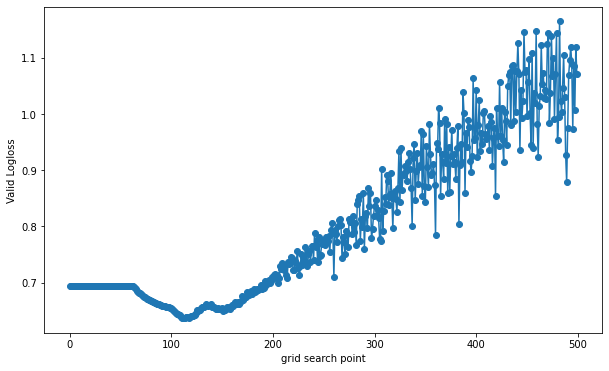

In [29]:
# Plot Loss vs point in grid search
data_out = 'data_lasso_06Arcene'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid Logloss")
plt.show()

In [30]:
# Train with best hyperparameters
params['C'] = best_C
log_clf = LogisticRegression(**params).fit(xtrain, ytrain.ravel())

In [31]:
# Save model and model's best params
data_out = 'data_lasso_06Arcene'
joblib.dump(log_clf, os.path.join(data_out, 'lasso_model.pkl'))
print("model saved at: '{}'".format(os.path.join(data_out, 'lasso_model.pkl')))

best_params = {}
best_params['C'] = best_C
with open(os.path.join(data_out, 'lasso_best_params.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'lasso_best_params.json')))

model saved at: 'data_lasso_06Arcene/lasso_model.pkl'
best params saved at: 'data_lasso_06Arcene/lasso_best_params.json'


In [32]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_lasso_06Arcene'
model = joblib.load(os.path.join(data_out, 'lasso_model.pkl'))

df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                           columns=['accuracy', 'roc_auc'])

ypred = model.predict(xtrain)
df_results.loc['train', 'accuracy'] = accuracy_score(ytrain, ypred)
df_results.loc['train', 'roc_auc']  = roc_auc_score(ytrain, ypred)

ypred = model.predict(xvalid)
df_results.loc['valid', 'accuracy'] = accuracy_score(yvalid, ypred)
df_results.loc['valid', 'roc_auc']  = roc_auc_score(yvalid, ypred)

ypred = model.predict(xtest)
df_results.loc['test', 'accuracy'] = accuracy_score(ytest, ypred)
df_results.loc['test', 'roc_auc']  = roc_auc_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target.csv')))
df_results.head()

model results saved at: 'data_lasso_06Arcene/results_target.csv'


,accuracy,roc_auc
train,0.808333,0.811735
valid,0.625,0.650895
test,0.575,0.665242


In [38]:
# Find Accuracy +/- STD
data_out = 'data_lasso_06Arcene/partitions'
df_results = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 'train_roc', 'valid_roc', 'test_roc'])

model = joblib.load('data_lasso_06Arcene/lasso_model.pkl')

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_06Arcene/X.csv', header=None)
    y = pd.read_csv('dataset_06Arcene/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .normalize data sets
    scaler = StandardScaler()
    scaler.fit(xtrain)
    xtrain = scaler.transform(xtrain)
    xvalid = scaler.transform(xvalid)
    xtest  = scaler.transform(xtest)
    
# .train model
    ytrain = ytrain.values.ravel()
    yvalid = yvalid.values.ravel()
    ytest  = ytest.values.ravel()
    model.fit(xtrain, ytrain)
    
# .compute/save accuracy
    ypred = model.predict(xtrain)
    df_results.loc[n, 'train_acc'] = accuracy_score(ytrain, ypred)
    df_results.loc[n, 'train_roc']  = roc_auc_score(ytrain, ypred)

    ypred = model.predict(xvalid)
    df_results.loc[n, 'valid_acc'] = accuracy_score(yvalid, ypred)
    df_results.loc[n, 'valid_roc']  = roc_auc_score(yvalid, ypred)

    ypred = model.predict(xtest)
    df_results.loc[n, 'test_acc'] = accuracy_score(ytest, ypred)
    df_results.loc[n, 'test_roc']  = roc_auc_score(ytest, ypred)

    joblib.dump(model, os.path.join(data_out, 'lasso_model_'+str(n)+'.pkl'))
    df_results.to_csv(os.path.join(data_out, 'accuracy_lasso.csv'), index=True)

In [99]:
# Display results
data_out = 'data_lasso_06Arcene'
accuracy_lasso = pd.read_csv(os.path.join(data_out, 'accuracy_lasso.csv'))
print("Train accuracy = {:.5f} +/- {:.5f}".format(accuracy_lasso['train_acc'].mean(), 
                                                  accuracy_lasso['train_acc'].std()))
print("Valid accuracy = {:.5f} +/- {:.5f}".format(accuracy_lasso['valid_acc'].mean(), 
                                                  accuracy_lasso['valid_acc'].std()))
print("Test accuracy = {:.5f} +/- {:.5f}".format(accuracy_lasso['test_acc'].mean(), 
                                                 accuracy_lasso['test_acc'].std()))

Train accuracy = 0.83983 +/- 0.02854
Valid accuracy = 0.71250 +/- 0.07312
Test accuracy = 0.71100 +/- 0.06707


### Gradient Boosting

In [48]:
# Load data
load_data('dataset_06Arcene')

# transform tensors to NumPy arrays
xtrain = xtrain.numpy()
xvalid = xvalid.numpy()
xtest = xtest.numpy()

ytrain = ytrain.numpy()
yvalid = yvalid.numpy()
ytest = ytest.numpy()

In [49]:
# Normalize data sets
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xvalid = scaler.transform(xvalid)
xtest  = scaler.transform(xtest)

In [50]:
# Build DMatrices
dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=10, feature_names=cols_all)
dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=10, feature_names=cols_all)
dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=10, feature_names=cols_all)

valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

In [76]:
# Grid search space
grid_eta   = np.geomspace(0.01, 1.0, num=100)
grid_depth = [1, 2, 3, 4, 5]
grid_param = [(eta, max_depth) for eta in grid_eta
                               for max_depth in grid_depth]

param = [('eta', 0.01), 
         ('max_depth', 2), 
         ('objective', 'binary:logistic'), 
         ('nthread', 4),
         ('eval_metric', 'logloss')
]

In [77]:
# Perform grid search
data_out = 'data_xgb_06Arcene'
df_grid_loss = pd.DataFrame(columns = ['eta', 'max_depth', 'valid_loss'], 
                            index = range(len(grid_param)))
i = 0
for eta, max_depth in grid_param:
    param[0] = ('eta', eta)
    param[1] = ('max_depth', max_depth)
    
    xgb_clf = xgb.train(param, dtrain, 
                        num_boost_round = 5000, 
                        evals = valid_list, 
                        early_stopping_rounds = 10, 
                        verbose_eval = False)
    
    print("eta={:.5f}, max_depth={} | valid_logloss={:.5f} (iters={})".format(eta, 
                                                                              max_depth, 
                                                                              xgb_clf.best_score, 
                                                                              xgb_clf.best_iteration))
    df_grid_loss.iloc[i,:] = [eta, max_depth, xgb_clf.best_score]
    i += 1
    
# .save grid search results
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid_loss.csv'), index=None)

eta=0.01000, max_depth=1 | valid_logloss=0.61376 (iters=287)
eta=0.01000, max_depth=2 | valid_logloss=0.56441 (iters=193)
eta=0.01000, max_depth=3 | valid_logloss=0.51696 (iters=298)
eta=0.01000, max_depth=4 | valid_logloss=0.53543 (iters=171)
eta=0.01000, max_depth=5 | valid_logloss=0.53443 (iters=207)
eta=0.01048, max_depth=1 | valid_logloss=0.61972 (iters=219)
eta=0.01048, max_depth=2 | valid_logloss=0.57198 (iters=147)
eta=0.01048, max_depth=3 | valid_logloss=0.52340 (iters=268)
eta=0.01048, max_depth=4 | valid_logloss=0.52726 (iters=199)
eta=0.01048, max_depth=5 | valid_logloss=0.53757 (iters=168)
eta=0.01097, max_depth=1 | valid_logloss=0.62042 (iters=199)
eta=0.01097, max_depth=2 | valid_logloss=0.56725 (iters=167)
eta=0.01097, max_depth=3 | valid_logloss=0.52536 (iters=256)
eta=0.01097, max_depth=4 | valid_logloss=0.52737 (iters=184)
eta=0.01097, max_depth=5 | valid_logloss=0.53766 (iters=160)
eta=0.01150, max_depth=1 | valid_logloss=0.62048 (iters=191)
eta=0.01150, max_depth=2

eta=0.03511, max_depth=2 | valid_logloss=0.56538 (iters=50)
eta=0.03511, max_depth=3 | valid_logloss=0.51212 (iters=84)
eta=0.03511, max_depth=4 | valid_logloss=0.52725 (iters=53)
eta=0.03511, max_depth=5 | valid_logloss=0.52980 (iters=58)
eta=0.03678, max_depth=1 | valid_logloss=0.61432 (iters=77)
eta=0.03678, max_depth=2 | valid_logloss=0.54430 (iters=83)
eta=0.03678, max_depth=3 | valid_logloss=0.51161 (iters=94)
eta=0.03678, max_depth=4 | valid_logloss=0.52899 (iters=53)
eta=0.03678, max_depth=5 | valid_logloss=0.53298 (iters=41)
eta=0.03854, max_depth=1 | valid_logloss=0.61362 (iters=78)
eta=0.03854, max_depth=2 | valid_logloss=0.55656 (iters=58)
eta=0.03854, max_depth=3 | valid_logloss=0.51626 (iters=77)
eta=0.03854, max_depth=4 | valid_logloss=0.52547 (iters=41)
eta=0.03854, max_depth=5 | valid_logloss=0.53210 (iters=46)
eta=0.04037, max_depth=1 | valid_logloss=0.61216 (iters=87)
eta=0.04037, max_depth=2 | valid_logloss=0.55876 (iters=54)
eta=0.04037, max_depth=3 | valid_logloss

eta=0.12328, max_depth=4 | valid_logloss=0.52240 (iters=14)
eta=0.12328, max_depth=5 | valid_logloss=0.50787 (iters=18)
eta=0.12915, max_depth=1 | valid_logloss=0.60715 (iters=19)
eta=0.12915, max_depth=2 | valid_logloss=0.55330 (iters=16)
eta=0.12915, max_depth=3 | valid_logloss=0.52189 (iters=21)
eta=0.12915, max_depth=4 | valid_logloss=0.50787 (iters=26)
eta=0.12915, max_depth=5 | valid_logloss=0.53564 (iters=20)
eta=0.13530, max_depth=1 | valid_logloss=0.60950 (iters=27)
eta=0.13530, max_depth=2 | valid_logloss=0.55120 (iters=28)
eta=0.13530, max_depth=3 | valid_logloss=0.53257 (iters=21)
eta=0.13530, max_depth=4 | valid_logloss=0.54964 (iters=8)
eta=0.13530, max_depth=5 | valid_logloss=0.52202 (iters=24)
eta=0.14175, max_depth=1 | valid_logloss=0.60586 (iters=28)
eta=0.14175, max_depth=2 | valid_logloss=0.55407 (iters=16)
eta=0.14175, max_depth=3 | valid_logloss=0.53894 (iters=14)
eta=0.14175, max_depth=4 | valid_logloss=0.51499 (iters=19)
eta=0.14175, max_depth=5 | valid_logloss=

eta=0.45349, max_depth=2 | valid_logloss=0.56780 (iters=6)
eta=0.45349, max_depth=3 | valid_logloss=0.47670 (iters=10)
eta=0.45349, max_depth=4 | valid_logloss=0.53930 (iters=7)
eta=0.45349, max_depth=5 | valid_logloss=0.53930 (iters=7)
eta=0.47508, max_depth=1 | valid_logloss=0.63896 (iters=11)
eta=0.47508, max_depth=2 | valid_logloss=0.56279 (iters=6)
eta=0.47508, max_depth=3 | valid_logloss=0.56958 (iters=4)
eta=0.47508, max_depth=4 | valid_logloss=0.54651 (iters=10)
eta=0.47508, max_depth=5 | valid_logloss=0.57772 (iters=4)
eta=0.49770, max_depth=1 | valid_logloss=0.60795 (iters=6)
eta=0.49770, max_depth=2 | valid_logloss=0.54069 (iters=11)
eta=0.49770, max_depth=3 | valid_logloss=0.59178 (iters=2)
eta=0.49770, max_depth=4 | valid_logloss=0.57421 (iters=4)
eta=0.49770, max_depth=5 | valid_logloss=0.57421 (iters=4)
eta=0.52140, max_depth=1 | valid_logloss=0.61011 (iters=6)
eta=0.52140, max_depth=2 | valid_logloss=0.58200 (iters=4)
eta=0.52140, max_depth=3 | valid_logloss=0.59222 (it

In [84]:
# Display grid search results
data_out = 'data_xgb_06Arcene'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
df_grid_loss.sort_values(by=['valid_loss'], ascending=True, inplace=True)

idx = 1
best_eta   = df_grid_loss.iloc[idx, 0]
best_depth = df_grid_loss.iloc[idx, 1]
best_loss  = df_grid_loss.iloc[idx, 2]
print("Best parameters:")
print("- Best eta = {:.3f}".format(best_eta))
print("- Best max_depth = {}".format(best_depth))
print("- Best valid loss = {}".format(best_loss))

Best parameters:
- Best eta = 0.394
- Best max_depth = 3
- Best valid loss = 0.443384


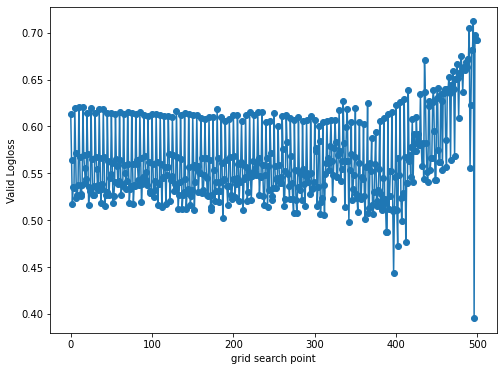

In [85]:
# Plot Loss vs point in grid search
data_out = 'data_xgb_06Arcene'
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid_loss.csv'))
fig, axes = plt.subplots(figsize=(8,6))
axes.scatter(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.plot(df_grid_loss.index, df_grid_loss['valid_loss'])
axes.set_xlabel("grid search point")
axes.set_ylabel("Valid Logloss")
plt.show()

In [87]:
# Train with best hyperparameters
param[0] = ('eta', best_eta)
param[1] = ('max_depth', best_depth)

evals_result = {}
xgb_clf = xgb.train(param, dtrain, 
                    num_boost_round = 5000, 
                    evals = valid_list, 
                    early_stopping_rounds = 30, 
                    verbose_eval = True, 
                    evals_result=evals_result)

[0]	train-logloss:0.45881	valid-logloss:0.63057
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 30 rounds.
[1]	train-logloss:0.33798	valid-logloss:0.59750
[2]	train-logloss:0.25494	valid-logloss:0.56529
[3]	train-logloss:0.19714	valid-logloss:0.51886
[4]	train-logloss:0.15924	valid-logloss:0.50266
[5]	train-logloss:0.12399	valid-logloss:0.46418
[6]	train-logloss:0.10080	valid-logloss:0.45878
[7]	train-logloss:0.08468	valid-logloss:0.46874
[8]	train-logloss:0.07374	valid-logloss:0.47385
[9]	train-logloss:0.06386	valid-logloss:0.46781
[10]	train-logloss:0.05709	valid-logloss:0.45909
[11]	train-logloss:0.05155	valid-logloss:0.46495
[12]	train-logloss:0.04670	valid-logloss:0.46138
[13]	train-logloss:0.04320	valid-logloss:0.45790
[14]	train-logloss:0.03960	valid-logloss:0.45503
[15]	train-logloss:0.03661	valid-logloss:0.44338
[16]	train-logloss:0.03433	valid-logloss:0.44496
[17]	train-logloss:0.03228

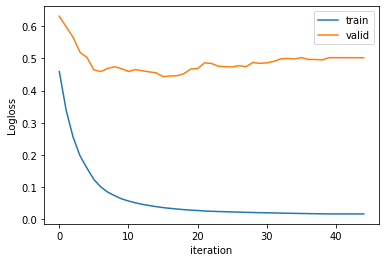

In [88]:
# Plot of train/valid loss vs iter
fig, axes = plt.subplots(figsize=(6,4))
axes.plot(evals_result['train']['logloss'], label="train")
axes.plot(evals_result['valid']['logloss'], label="valid")
axes.legend()
axes.set_ylabel("Logloss")
axes.set_xlabel("iteration")
# axes.set_xticks(np.arange(0, len(evals_result['train']['logloss']), 1))
plt.show()

In [89]:
# Save model and model's best params
data_out = 'data_xgb_06Arcene'
xgb_clf.save_model(os.path.join(data_out, 'xgb_model.json'))
print("model saved at: '{}'".format(os.path.join(data_out, 'xgb_model.json')))

best_params = {}
best_params['best_eta'] = best_eta
best_params['best_depth'] = int(best_depth)
with open(os.path.join(data_out, 'xgb_best_params.json'), 'w') as f:
    json.dump(best_params, f)
print("best params saved at: '{}'".format(os.path.join(data_out, 'xgb_best_params.json')))

model saved at: 'data_xgb_06Arcene/xgb_model.json'
best params saved at: 'data_xgb_06Arcene/xgb_best_params.json'


In [90]:
# Save feature map
def ceate_feature_map(features, data_out):
    f = open(os.path.join(data_out, 'xgb_model_fmap.txt'), 'w')
    i = 0
    for feat in features:
        f.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    f.close()

data_out = 'data_xgb_06Arcene'
ceate_feature_map(cols_all, data_out)
print("feature map saved at: '{}'".format(os.path.join(data_out, 'xgb_model_fmap.txt')))

feature map saved at: 'data_xgb_06Arcene/xgb_model_fmap.txt'


In [92]:
# Find MSE, R2, Accuracy, etc...
data_out = 'data_xgb_06Arcene'
model = xgb.Booster(model_file=os.path.join(data_out, 'xgb_model.json'))
df_results = pd.DataFrame(index=['train', 'valid', 'test'], 
                          columns=['accuracy', 'roc_auc'])

ypred = model.predict(dtrain)
ypred = ypred.round().astype(int)
df_results.loc['train', 'accuracy'] = accuracy_score(ytrain, ypred)
df_results.loc['train', 'roc_auc']  = roc_auc_score(ytrain, ypred)

ypred = model.predict(dvalid)
ypred = ypred.round().astype(int)
df_results.loc['valid', 'accuracy'] = accuracy_score(yvalid, ypred)
df_results.loc['valid', 'roc_auc']  = roc_auc_score(yvalid, ypred)

ypred = model.predict(dtest)
ypred = ypred.round().astype(int)
df_results.loc['test', 'accuracy'] = accuracy_score(ytest, ypred)
df_results.loc['test', 'roc_auc']  = roc_auc_score(ytest, ypred)

# Save data
df_results.to_csv(os.path.join(data_out, 'results_target_xgb.csv'), index=True)
print("model results saved at: '{}'".format(os.path.join(data_out, 'results_target_xgb.csv')))
df_results.head()

model results saved at: 'data_xgb_06Arcene/results_target_xgb.csv'


,accuracy,roc_auc
train,1,1
valid,0.775,0.789003
test,0.725,0.736467


In [97]:
# Find Accuracy +/- STD
data_out = 'data_xgb_06Arcene/partitions'
df_results = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 'train_roc', 'valid_roc', 'test_roc'])

with open('data_xgb_06Arcene/xgb_best_params.json') as f:
    best_params = json.load(f)
param = [('eta', best_params['best_eta']), 
         ('max_depth', best_params['best_depth']), 
         ('objective', 'binary:logistic'), 
         ('nthread', 8),
         ('eval_metric', 'logloss')
]

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_06Arcene/X.csv', header=None)
    y = pd.read_csv('dataset_06Arcene/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])
    
# .build DMatrices
    dtrain = xgb.DMatrix(data=xtrain, label=ytrain, nthread=16)
    dvalid = xgb.DMatrix(data=xvalid, label=yvalid, nthread=16)
    dtest  = xgb.DMatrix(data=xtest,  label=ytest,  nthread=16)
    valid_list = [(dtrain, 'train'), (dvalid, 'valid')]

# .train model
    evals_result = {}
    model = xgb.train(param, dtrain, 
                      num_boost_round = 5000, 
                      evals = valid_list, 
                      early_stopping_rounds = 20, 
                      verbose_eval = False, 
                      evals_result=evals_result)
    
# .compute/save accuracy
    ypred = model.predict(dtrain)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'train_acc'] = accuracy_score(ytrain, ypred)
    df_results.loc[n, 'train_roc'] = roc_auc_score(ytrain, ypred)

    ypred = model.predict(dvalid)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'valid_acc'] = accuracy_score(yvalid, ypred)
    df_results.loc[n, 'valid_roc'] = roc_auc_score(yvalid, ypred)

    ypred = model.predict(dtest)
    ypred = ypred.round().astype(int)
    df_results.loc[n, 'test_acc'] = accuracy_score(ytest, ypred)
    df_results.loc[n, 'test_roc'] = roc_auc_score(ytest, ypred)

    model.save_model(os.path.join(data_out, 'xgb_model_'+str(n)+'.json'))
    df_results.to_csv('data_xgb_06Arcene/accuracy_xgb.csv', index=None)

In [100]:
# Display results
data_out = 'data_xgb_06Arcene'
accuracy_xgb = pd.read_csv(os.path.join(data_out, 'accuracy_xgb.csv'))
print("Train accuracy = {:.5f} +/- {:.5f}".format(accuracy_xgb['train_acc'].mean(), 
                                                  accuracy_xgb['train_acc'].std()))
print("Valid accuracy = {:.5f} +/- {:.5f}".format(accuracy_xgb['valid_acc'].mean(), 
                                                  accuracy_xgb['valid_acc'].std()))
print("Test accuracy = {:.5f} +/- {:.5f}".format(accuracy_xgb['test_acc'].mean(), 
                                                 accuracy_xgb['test_acc'].std()))

Train accuracy = 1.00000 +/- 0.00000
Valid accuracy = 0.75475 +/- 0.06860
Test accuracy = 0.76250 +/- 0.07217


### Lockout

In [101]:
# Normalize Data Set
def normalize_data():
    """
    """
    global xtrain, xvalid, xtest
    scaler = StandardScaler()
    scaler.fit(xtrain.numpy())
    xtrain = torch.from_numpy(scaler.transform(xtrain.numpy()))
    xvalid = torch.from_numpy(scaler.transform(xvalid.numpy()))
    xtest = torch.from_numpy(scaler.transform(xtest.numpy()))

In [102]:
# Save output data
def save_output(data_out, f1, f2, f3, new_folder=False):
    """
    """
# Save relevant data
    if new_folder == True:
        dirs = os.listdir()
        if data_out in dirs:
            print("'{}' directory deleted.".format(data_out))
            shutil.rmtree(data_out)
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
        else:
            print("'{}' directory created.\n".format(data_out))
            os.mkdir(data_out)
# 
    train_loss.to_csv(os.path.join(data_out, f1), index=False)
    valid_loss.to_csv(os.path.join(data_out, f2), index=False)
    print("'{}' saved.".format(f1))
    print("'{}' saved.".format(f2))

    for m in f3:
        shutil.move(m, os.path.join(data_out, m))
        print("'{}' saved.".format(m))

#### l1=5, l2=2; lockout=l1

In [103]:
# Set layers where lockdown is to be applied
def get_lockdown_layers(model):
    layers = [model.classifier[0]]
    return layers

In [104]:
#  NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [240]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_loss', 'valid_acc'], 
                            index=range(len(grid_lrs)))

In [243]:
# Perform grid search (unconstrained)
layer_sizes = [5, 2]
epochs = 30000
data_in = 'dataset_06Arcene'
data_out = "data_unconstrained_06Arcene/lrs"
lock_flag = False

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    fname = 'model06_forward_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train06_loss_'+str(n)+'.csv', 
                'valid06_loss_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

# .save grid search results
    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], loss.detach().item(), accu]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid06_forward.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00050
-Model saved after iteration 619.
-Train.  Loss=0.1772269
-Valid.  Loss=0.5962036

Best train loss = 0.0007888

'train06_loss_1.csv' saved.
'valid06_loss_1.csv' saved.
'model06_forward_1_last.pth' saved.
'model06_forward_1_best.pth' saved.



Summary:
-learning rate = 0.00090
-Model saved after iteration 76.
-Train.  Loss=0.4755042
-Valid.  Loss=0.7023974

Best train loss = 0.0222556

'train06_loss_2.csv' saved.
'valid06_loss_2.csv' saved.
'model06_forward_2_last.pth' saved.
'model06_forward_2_best.pth' saved.



Summary:
-learning rate = 0.00162
-Model saved after iteration 52.
-Train.  Loss=0.3577821
-Valid.  Loss=0.6089116

Best train loss = 0.0001823

'train06_loss_3.csv' saved.
'valid06_loss_3.csv' saved.
'model06_forward_3_last.pth' saved.
'model06_forward_3_best.pth' saved.



Summary:
-learning rate = 0.00292
-Model saved after iteration 133.
-Train.  Loss=0.2399644
-Valid.  Loss=0.6061637

Best train loss = 0.0058889

'train06_loss_4.csv' saved.
'valid06_loss_4.csv' saved.
'model06_forward_4_last.pth' saved.
'model06_forward_4_best.pth' saved.



Summary:
-learning rate = 0.00527
-Model saved after iteration 46.
-Train.  Loss=0.1534166
-Valid.  Loss=0.5309490

Best train loss = 0.0000461

'train06_loss_5.csv' saved.
'valid06_loss_5.csv' saved.
'model06_forward_5_last.pth' saved.
'model06_forward_5_best.pth' saved.



Summary:
-learning rate = 0.00949
-Model saved after iteration 26.
-Train.  Loss=0.1818641
-Valid.  Loss=0.5864490

Best train loss = 0.0577803

'train06_loss_6.csv' saved.
'valid06_loss_6.csv' saved.
'model06_forward_6_last.pth' saved.
'model06_forward_6_best.pth' saved.



Summary:
-learning rate = 0.01710
-Model saved after iteration 6.
-Train.  Loss=0.5098477
-Valid.  Loss=0.6594453

Best train loss = 0.0010113

'train06_loss_7.csv' saved.
'valid06_loss_7.csv' saved.
'model06_forward_7_last.pth' saved.
'model06_forward_7_best.pth' saved.



Summary:
-learning rate = 0.03081
-Model saved after iteration 11.
-Train.  Loss=0.2556333
-Valid.  Loss=0.6627086

Best train loss = 0.0005728

'train06_loss_8.csv' saved.
'valid06_loss_8.csv' saved.
'model06_forward_8_last.pth' saved.
'model06_forward_8_best.pth' saved.



Summary:
-learning rate = 0.05550
-Model saved after iteration 3.
-Train.  Loss=0.5645226
-Valid.  Loss=0.5902807

Best train loss = 0.0003084

'train06_loss_9.csv' saved.
'valid06_loss_9.csv' saved.
'model06_forward_9_last.pth' saved.
'model06_forward_9_best.pth' saved.



Summary:
-learning rate = 0.10000
-Model saved after iteration 24.
-Train.  Loss=0.1783623
-Valid.  Loss=0.6279147

Best train loss = 0.0001693

'train06_loss_10.csv' saved.
'valid06_loss_10.csv' saved.
'model06_forward_10_last.pth' saved.
'model06_forward_10_best.pth' saved.



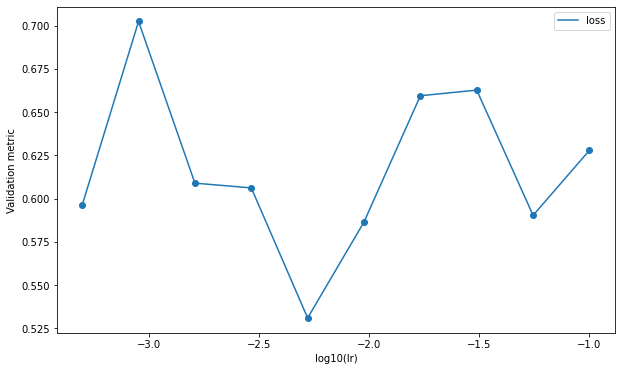

In [244]:
# Plot Loss vs point in grid search
data_out = "data_unconstrained_06Arcene/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid06_forward.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'], label='loss')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [257]:
# Display grid search results
data_out = "data_unconstrained_06Arcene/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid06_forward.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_lr_fward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_fward))
print("- Best valid mse = {}".format(best_mse))

# Copy best model to main directory
shutil.copy("data_unconstrained_06Arcene/lrs/model06_forward_"+str(idx+1)+"_best.pth", 
            "data_unconstrained_06Arcene/model06_forward_best.pth")
shutil.copy("data_unconstrained_06Arcene/lrs/model06_forward_"+str(idx+1)+"_last.pth", 
            "data_unconstrained_06Arcene/model06_forward_last.pth")

shutil.copy("data_unconstrained_06Arcene/lrs/train06_loss_"+str(idx+1)+".csv", 
            "data_unconstrained_06Arcene/train06_loss.csv")
shutil.copy("data_unconstrained_06Arcene/lrs/valid06_loss_"+str(idx+1)+".csv", 
            "data_unconstrained_06Arcene/valid06_loss.csv")

Best parameters (5):
- Best lr = 0.00527
- Best valid mse = 0.5309489965438843


'data_unconstrained_06Arcene/valid06_loss.csv'

In [252]:
# Grid search space
grid_lrs = np.geomspace(5e-4, 1e-1, num=10)
df_grid_loss = pd.DataFrame(columns = ['lr', 'valid_loss', 'valid_acc'], 
                            index=range(len(grid_lrs)))

In [253]:
# Perform grid search (lockdown)
layer_sizes = [5, 2]
epochs = 20000
data_in = 'dataset_06Arcene'
data_out = "data_lockdown_06Arcene/lrs"
lock_flag = True
step = 1

# Read data
load_data(data_in)

# Normalize data
normalize_data()

# Create DataLoaders
make_DataLoaders()
features = xtrain.size(1)

# Train model
iterator = tqdm.notebook.tqdm(range(1, len(grid_lrs) + 1), desc='lr-grid loop')
for n in iterator:
    irow = n-1
    model_forward_name = 'data_unconstrained_06Arcene/lrs/model06_forward_'+str(n)+'_last.pth'
    fname = 'model06_backward_'+str(n)
    train_loss, valid_loss = train_model(
                             grid_lrs[irow], 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs=epochs,
                             early_stop=epochs, 
                             fname=fname)
    print('\nBest train loss = {:.7f}\n'.format(train_loss['loss'].min()))

# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train06_loss_'+str(n)+'.csv', 
                'valid06_loss_'+str(n)+'.csv', f3)
    
# .find MSE, R2, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()

# .save grid search results
    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    df_grid_loss.iloc[irow,:] = [grid_lrs[irow], loss.detach().item(), accu]
    df_grid_loss.to_csv(os.path.join(data_out, 'df_grid06_backward.csv'), index=None)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00050
-Model saved after iteration 19613.
-Train.  Loss=0.2444573
-Valid.  Loss=0.5415932

Best train loss = 0.0000000

'train06_loss_1.csv' saved.
'valid06_loss_1.csv' saved.
'model06_backward_1_best.pth' saved.



Summary:
-learning rate = 0.00090
-Model saved after iteration 19369.
-Train.  Loss=0.3175108
-Valid.  Loss=0.6887647

Best train loss = 0.0143216

'train06_loss_2.csv' saved.
'valid06_loss_2.csv' saved.
'model06_backward_2_best.pth' saved.



Summary:
-learning rate = 0.00162
-Model saved after iteration 19451.
-Train.  Loss=0.3043469
-Valid.  Loss=0.6625994

Best train loss = 0.0000000

'train06_loss_3.csv' saved.
'valid06_loss_3.csv' saved.
'model06_backward_3_best.pth' saved.



Summary:
-learning rate = 0.00292
-Model saved after iteration 19539.
-Train.  Loss=0.2667362
-Valid.  Loss=0.6620946

Best train loss = 0.0000063

'train06_loss_4.csv' saved.
'valid06_loss_4.csv' saved.
'model06_backward_4_best.pth' saved.



Summary:
-learning rate = 0.00527
-Model saved after iteration 5.
-Train.  Loss=0.0000351
-Valid.  Loss=0.5971515

Best train loss = 0.0000000

'train06_loss_5.csv' saved.
'valid06_loss_5.csv' saved.
'model06_backward_5_best.pth' saved.



Summary:
-learning rate = 0.00949
-Model saved after iteration 19195.
-Train.  Loss=0.2364158
-Valid.  Loss=0.5444075

Best train loss = 0.0037206

'train06_loss_6.csv' saved.
'valid06_loss_6.csv' saved.
'model06_backward_6_best.pth' saved.



Summary:
-learning rate = 0.01710
-Model saved after iteration 19306.
-Train.  Loss=0.4149508
-Valid.  Loss=0.4115285

Best train loss = 0.0000000

'train06_loss_7.csv' saved.
'valid06_loss_7.csv' saved.
'model06_backward_7_best.pth' saved.



Summary:
-learning rate = 0.03081
-Model saved after iteration 18116.
-Train.  Loss=0.1542618
-Valid.  Loss=0.4372530

Best train loss = 0.0000000

'train06_loss_8.csv' saved.
'valid06_loss_8.csv' saved.
'model06_backward_8_best.pth' saved.



Summary:
-learning rate = 0.05550
-Model saved after iteration 18165.
-Train.  Loss=0.5403224
-Valid.  Loss=0.5440348

Best train loss = 0.0000001

'train06_loss_9.csv' saved.
'valid06_loss_9.csv' saved.
'model06_backward_9_best.pth' saved.



Summary:
-learning rate = 0.10000
-Model saved after iteration 18055.
-Train.  Loss=0.4754596
-Valid.  Loss=0.5579063

Best train loss = 0.0001693

'train06_loss_10.csv' saved.
'valid06_loss_10.csv' saved.
'model06_backward_10_best.pth' saved.



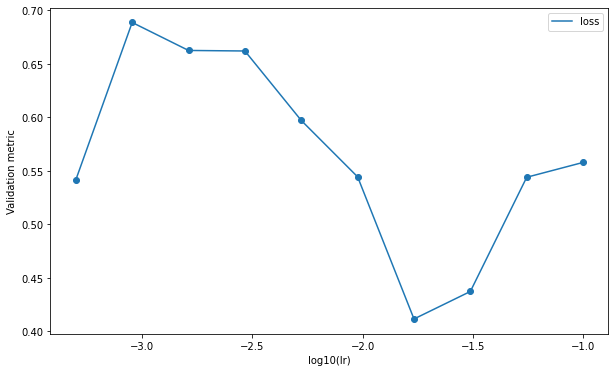

In [254]:
# Plot Loss vs point in grid search
data_out = "data_lockdown_06Arcene/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid06_backward.csv'))
fig, axes = plt.subplots(figsize=(10,6))
axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'])
axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_loss'], label='loss')
# axes.scatter(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'])
# axes.plot(np.log10(df_grid_loss.lr), df_grid_loss['valid_r2'], label='r2')
axes.set_xlabel("log10(lr)")
axes.set_ylabel("Validation metric")
axes.legend()
plt.show()

In [274]:
# Display grid search results
data_out = "data_lockdown_06Arcene/lrs"
df_grid_loss = pd.read_csv(os.path.join(data_out, 'df_grid06_backward.csv'))

idx = df_grid_loss.valid_loss.idxmin()
best_lr_bward = df_grid_loss.iloc[idx, 0]
best_mse      = df_grid_loss.iloc[idx, 1]
print("Best parameters ({}):".format(idx+1))
print("- Best lr = {:.5f}".format(best_lr_bward))
print("- Best valid mse = {}".format(best_mse))

# Copy best models to main directory
shutil.copy("data_unconstrained_06Arcene/lrs/model06_forward_"+str(idx+1)+"_best.pth", 
            "data_lockdown_06Arcene/model06_fward_best.pth")
shutil.copy("data_unconstrained_06Arcene/lrs/model06_forward_"+str(idx+1)+"_last.pth", 
            "data_lockdown_06Arcene/model06_fward_last.pth")
shutil.copy("data_lockdown_06Arcene/lrs/model06_backward_"+str(idx+1)+"_best.pth", 
            "data_lockdown_06Arcene/model06_backward_best.pth")

shutil.copy("data_unconstrained_06Arcene/lrs/train06_loss_"+str(idx+1)+".csv", 
            "data_lockdown_06Arcene/train_loss_fward.csv")
shutil.copy("data_unconstrained_06Arcene/lrs/valid06_loss_"+str(idx+1)+".csv", 
            "data_lockdown_06Arcene/valid_loss_fward.csv")
shutil.copy("data_lockdown_06Arcene/lrs/train06_loss_"+str(idx+1)+".csv", 
            "data_lockdown_06Arcene/train_loss.csv")
shutil.copy("data_lockdown_06Arcene/lrs/valid06_loss_"+str(idx+1)+".csv", 
            "data_lockdown_06Arcene/valid_loss.csv")

Best parameters (7):
- Best lr = 0.01710
- Best valid mse = 0.4115285277366638


'data_lockdown_06Arcene/valid_loss.csv'

In [275]:
# Find Loss, Accuracy, etc...
data_out = "data_lockdown_06Arcene"
index = pd.MultiIndex.from_product([['TRAIN', 'VALIDATION', 'TEST'], ['forward', 'lockdown']])
df_results = pd.DataFrame(index=index, columns=['LOSS', 'ACCURACY'])

# Unconstrained results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_unconstrained_06Arcene/model06_forward_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
loss = loss_type(ypred, ytrain.view(-1))
accu = dataset_accuracy(train_dataloader, mm, device)
df_results.loc[('TRAIN', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('TRAIN', 'forward'), 'ACCURACY'] = accu

ypred = mm(xvalid)
loss = loss_type(ypred, yvalid.view(-1))
accu = dataset_accuracy(valid_dataloader, mm, device)
df_results.loc[('VALIDATION', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('VALIDATION', 'forward'), 'ACCURACY'] = accu

ypred = mm(xtest)
loss = loss_type(ypred, ytest.view(-1))
accu = dataset_accuracy(test_dataloader, mm, device)
df_results.loc[('TEST', 'forward'), 'LOSS'] = loss.detach().item()
df_results.loc[('TEST', 'forward'), 'ACCURACY'] = accu

# Lockdown results
mm = MyNet(features, layer_sizes)
mm.load_state_dict(torch.load('data_lockdown_06Arcene/model06_backward_best.pth'))
mm = mm.to(device)
mm.eval()

ypred = mm(xtrain)
loss = loss_type(ypred, ytrain.view(-1))
accu = dataset_accuracy(train_dataloader, mm, device)
df_results.loc[('TRAIN', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('TRAIN', 'lockdown'), 'ACCURACY'] = accu

ypred = mm(xvalid)
loss = loss_type(ypred, yvalid.view(-1))
accu = dataset_accuracy(valid_dataloader, mm, device)
df_results.loc[('VALIDATION', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('VALIDATION', 'lockdown'), 'ACCURACY'] = accu

ypred = mm(xtest)
loss = loss_type(ypred, ytest.view(-1))
accu = dataset_accuracy(test_dataloader, mm, device)
df_results.loc[('TEST', 'lockdown'), 'LOSS'] = loss.detach().item()
df_results.loc[('TEST', 'lockdown'), 'ACCURACY'] = accu

df_results.to_csv(os.path.join(data_out, 'results.csv'), index=True)
df_results

LOSS  ACCURACY
TRAIN      forward   0.153417         1
           lockdown  0.414951  0.733333
VALIDATION forward   0.530949       0.7
           lockdown  0.411529     0.775
TEST       forward     0.4049      0.75
           lockdown  0.449003     0.775

In [282]:
# Find Accuracy, Loss +/- STD (Forward)
data_output = 'data_unconstrained_06Arcene'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_06Arcene/X.csv', header=None)
    y = pd.read_csv('dataset_06Arcene/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_fward
    layer_sizes = [5, 2]
    epochs = 30000
    data_out = "data_unconstrained_06Arcene/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model06_forward_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = 5000, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss_'+str(n)+'.csv', 
                'valid_loss_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy06_forward.csv'), index=True)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 52.
-Train.  Loss=0.2495074
-Valid.  Loss=0.4962537
'train_loss_1.csv' saved.
'valid_loss_1.csv' saved.
'model06_forward_1_last.pth' saved.
'model06_forward_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 140.
-Train.  Loss=0.1191348
-Valid.  Loss=0.4589560
'train_loss_2.csv' saved.
'valid_loss_2.csv' saved.
'model06_forward_2_last.pth' saved.
'model06_forward_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 85.
-Train.  Loss=0.1699090
-Valid.  Loss=0.5015782
'train_loss_3.csv' saved.
'valid_loss_3.csv' saved.
'model06_forward_3_last.pth' saved.
'model06_forward_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 200.
-Train.  Loss=0.1145268
-Valid.  Loss=0.5276027
'train_loss_4.csv' saved.
'valid_loss_4.csv' saved.
'model06_forward_4_last.pth' saved.
'model06_forward_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 44.
-Train.  Loss=0.2828650
-Valid.  Loss=0.4729902
'train_loss_5.csv' saved.
'valid_loss_5.csv' saved.
'model06_forward_5_last.pth' saved.
'model06_forward_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 47.
-Train.  Loss=0.2205706
-Valid.  Loss=0.4153580
'train_loss_6.csv' saved.
'valid_loss_6.csv' saved.
'model06_forward_6_last.pth' saved.
'model06_forward_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 272.
-Train.  Loss=0.0270917
-Valid.  Loss=0.3833446
'train_loss_7.csv' saved.
'valid_loss_7.csv' saved.
'model06_forward_7_last.pth' saved.
'model06_forward_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 4120.
-Train.  Loss=0.0123378
-Valid.  Loss=0.2333841
'train_loss_8.csv' saved.
'valid_loss_8.csv' saved.
'model06_forward_8_last.pth' saved.
'model06_forward_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 162.
-Train.  Loss=0.1446682
-Valid.  Loss=0.7072574
'train_loss_9.csv' saved.
'valid_loss_9.csv' saved.
'model06_forward_9_last.pth' saved.
'model06_forward_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 22.
-Train.  Loss=0.4589940
-Valid.  Loss=0.5876127
'train_loss_10.csv' saved.
'valid_loss_10.csv' saved.
'model06_forward_10_last.pth' saved.
'model06_forward_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 745.
-Train.  Loss=0.0044099
-Valid.  Loss=0.5033709
'train_loss_11.csv' saved.
'valid_loss_11.csv' saved.
'model06_forward_11_last.pth' saved.
'model06_forward_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29992.
-Train.  Loss=0.0033057
-Valid.  Loss=0.4262860
'train_loss_12.csv' saved.
'valid_loss_12.csv' saved.
'model06_forward_12_last.pth' saved.
'model06_forward_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 39.
-Train.  Loss=0.4204213
-Valid.  Loss=0.6680477
'train_loss_13.csv' saved.
'valid_loss_13.csv' saved.
'model06_forward_13_last.pth' saved.
'model06_forward_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 9755.
-Train.  Loss=0.0106924
-Valid.  Loss=0.5083029
'train_loss_14.csv' saved.
'valid_loss_14.csv' saved.
'model06_forward_14_last.pth' saved.
'model06_forward_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 291.
-Train.  Loss=0.0998483
-Valid.  Loss=0.5314911
'train_loss_15.csv' saved.
'valid_loss_15.csv' saved.
'model06_forward_15_last.pth' saved.
'model06_forward_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 98.
-Train.  Loss=0.1245480
-Valid.  Loss=0.8897694
'train_loss_16.csv' saved.
'valid_loss_16.csv' saved.
'model06_forward_16_last.pth' saved.
'model06_forward_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 265.
-Train.  Loss=0.0896542
-Valid.  Loss=0.2975403
'train_loss_17.csv' saved.
'valid_loss_17.csv' saved.
'model06_forward_17_last.pth' saved.
'model06_forward_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 19.
-Train.  Loss=0.3097942
-Valid.  Loss=0.5572806
'train_loss_18.csv' saved.
'valid_loss_18.csv' saved.
'model06_forward_18_last.pth' saved.
'model06_forward_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 38.
-Train.  Loss=0.3636673
-Valid.  Loss=0.6799409
'train_loss_19.csv' saved.
'valid_loss_19.csv' saved.
'model06_forward_19_last.pth' saved.
'model06_forward_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 59.
-Train.  Loss=0.3273279
-Valid.  Loss=0.5055822
'train_loss_20.csv' saved.
'valid_loss_20.csv' saved.
'model06_forward_20_last.pth' saved.
'model06_forward_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 240.
-Train.  Loss=0.0357557
-Valid.  Loss=0.3889656
'train_loss_21.csv' saved.
'valid_loss_21.csv' saved.
'model06_forward_21_last.pth' saved.
'model06_forward_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 894.
-Train.  Loss=0.0952376
-Valid.  Loss=0.2558783
'train_loss_22.csv' saved.
'valid_loss_22.csv' saved.
'model06_forward_22_last.pth' saved.
'model06_forward_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 349.
-Train.  Loss=0.1349376
-Valid.  Loss=0.5421999
'train_loss_23.csv' saved.
'valid_loss_23.csv' saved.
'model06_forward_23_last.pth' saved.
'model06_forward_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 119.
-Train.  Loss=0.1982773
-Valid.  Loss=0.5134617
'train_loss_24.csv' saved.
'valid_loss_24.csv' saved.
'model06_forward_24_last.pth' saved.
'model06_forward_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 13.
-Train.  Loss=0.4375220
-Valid.  Loss=0.8373443
'train_loss_25.csv' saved.
'valid_loss_25.csv' saved.
'model06_forward_25_last.pth' saved.
'model06_forward_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 24.
-Train.  Loss=0.2409013
-Valid.  Loss=0.5434418
'train_loss_26.csv' saved.
'valid_loss_26.csv' saved.
'model06_forward_26_last.pth' saved.
'model06_forward_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 2113.
-Train.  Loss=0.0017060
-Valid.  Loss=0.3484323
'train_loss_27.csv' saved.
'valid_loss_27.csv' saved.
'model06_forward_27_last.pth' saved.
'model06_forward_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 105.
-Train.  Loss=0.0704524
-Valid.  Loss=0.3865390
'train_loss_28.csv' saved.
'valid_loss_28.csv' saved.
'model06_forward_28_last.pth' saved.
'model06_forward_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 163.
-Train.  Loss=0.0527716
-Valid.  Loss=0.4098667
'train_loss_29.csv' saved.
'valid_loss_29.csv' saved.
'model06_forward_29_last.pth' saved.
'model06_forward_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 63.
-Train.  Loss=0.1887016
-Valid.  Loss=0.6651482
'train_loss_30.csv' saved.
'valid_loss_30.csv' saved.
'model06_forward_30_last.pth' saved.
'model06_forward_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 1415.
-Train.  Loss=0.0727989
-Valid.  Loss=0.5814348
'train_loss_31.csv' saved.
'valid_loss_31.csv' saved.
'model06_forward_31_last.pth' saved.
'model06_forward_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 24.
-Train.  Loss=0.2512462
-Valid.  Loss=0.5826439
'train_loss_32.csv' saved.
'valid_loss_32.csv' saved.
'model06_forward_32_last.pth' saved.
'model06_forward_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29996.
-Train.  Loss=0.0000486
-Valid.  Loss=0.1052368
'train_loss_33.csv' saved.
'valid_loss_33.csv' saved.
'model06_forward_33_last.pth' saved.
'model06_forward_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 141.
-Train.  Loss=0.0574333
-Valid.  Loss=0.3266942
'train_loss_34.csv' saved.
'valid_loss_34.csv' saved.
'model06_forward_34_last.pth' saved.
'model06_forward_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 207.
-Train.  Loss=0.0810056
-Valid.  Loss=0.4888825
'train_loss_35.csv' saved.
'valid_loss_35.csv' saved.
'model06_forward_35_last.pth' saved.
'model06_forward_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 81.
-Train.  Loss=0.3134827
-Valid.  Loss=0.6071268
'train_loss_36.csv' saved.
'valid_loss_36.csv' saved.
'model06_forward_36_last.pth' saved.
'model06_forward_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 46.
-Train.  Loss=0.2449753
-Valid.  Loss=0.4784644
'train_loss_37.csv' saved.
'valid_loss_37.csv' saved.
'model06_forward_37_last.pth' saved.
'model06_forward_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 73.
-Train.  Loss=0.2889284
-Valid.  Loss=0.6831935
'train_loss_38.csv' saved.
'valid_loss_38.csv' saved.
'model06_forward_38_last.pth' saved.
'model06_forward_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 474.
-Train.  Loss=0.0453703
-Valid.  Loss=0.4300963
'train_loss_39.csv' saved.
'valid_loss_39.csv' saved.
'model06_forward_39_last.pth' saved.
'model06_forward_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 1143.
-Train.  Loss=0.0025107
-Valid.  Loss=0.4682215
'train_loss_40.csv' saved.
'valid_loss_40.csv' saved.
'model06_forward_40_last.pth' saved.
'model06_forward_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29993.
-Train.  Loss=0.0000461
-Valid.  Loss=0.1708994
'train_loss_41.csv' saved.
'valid_loss_41.csv' saved.
'model06_forward_41_last.pth' saved.
'model06_forward_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 139.
-Train.  Loss=0.0557695
-Valid.  Loss=0.5324684
'train_loss_42.csv' saved.
'valid_loss_42.csv' saved.
'model06_forward_42_last.pth' saved.
'model06_forward_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 258.
-Train.  Loss=0.0230885
-Valid.  Loss=0.4018843
'train_loss_43.csv' saved.
'valid_loss_43.csv' saved.
'model06_forward_43_last.pth' saved.
'model06_forward_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 36.
-Train.  Loss=0.2512372
-Valid.  Loss=0.6758945
'train_loss_44.csv' saved.
'valid_loss_44.csv' saved.
'model06_forward_44_last.pth' saved.
'model06_forward_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 112.
-Train.  Loss=0.1685449
-Valid.  Loss=0.5157471
'train_loss_45.csv' saved.
'valid_loss_45.csv' saved.
'model06_forward_45_last.pth' saved.
'model06_forward_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 46.
-Train.  Loss=0.3704875
-Valid.  Loss=0.7055072
'train_loss_46.csv' saved.
'valid_loss_46.csv' saved.
'model06_forward_46_last.pth' saved.
'model06_forward_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 267.
-Train.  Loss=0.0167165
-Valid.  Loss=0.3853948
'train_loss_47.csv' saved.
'valid_loss_47.csv' saved.
'model06_forward_47_last.pth' saved.
'model06_forward_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 15.
-Train.  Loss=0.4198885
-Valid.  Loss=0.6262707
'train_loss_48.csv' saved.
'valid_loss_48.csv' saved.
'model06_forward_48_last.pth' saved.
'model06_forward_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 40.
-Train.  Loss=0.4260111
-Valid.  Loss=0.5285096
'train_loss_49.csv' saved.
'valid_loss_49.csv' saved.
'model06_forward_49_last.pth' saved.
'model06_forward_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 873.
-Train.  Loss=0.1383712
-Valid.  Loss=0.7013320
'train_loss_50.csv' saved.
'valid_loss_50.csv' saved.
'model06_forward_50_last.pth' saved.
'model06_forward_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 4.
-Train.  Loss=0.5737576
-Valid.  Loss=0.6795493
'train_loss_51.csv' saved.
'valid_loss_51.csv' saved.
'model06_forward_51_last.pth' saved.
'model06_forward_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 77.
-Train.  Loss=0.1572305
-Valid.  Loss=0.4787375
'train_loss_52.csv' saved.
'valid_loss_52.csv' saved.
'model06_forward_52_last.pth' saved.
'model06_forward_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 97.
-Train.  Loss=0.1431617
-Valid.  Loss=0.4921606
'train_loss_53.csv' saved.
'valid_loss_53.csv' saved.
'model06_forward_53_last.pth' saved.
'model06_forward_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 39.
-Train.  Loss=0.2630530
-Valid.  Loss=0.5047483
'train_loss_54.csv' saved.
'valid_loss_54.csv' saved.
'model06_forward_54_last.pth' saved.
'model06_forward_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 320.
-Train.  Loss=0.0230829
-Valid.  Loss=0.6541907
'train_loss_55.csv' saved.
'valid_loss_55.csv' saved.
'model06_forward_55_last.pth' saved.
'model06_forward_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 140.
-Train.  Loss=0.1219015
-Valid.  Loss=0.4784652
'train_loss_56.csv' saved.
'valid_loss_56.csv' saved.
'model06_forward_56_last.pth' saved.
'model06_forward_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 22.
-Train.  Loss=0.3371089
-Valid.  Loss=0.6505741
'train_loss_57.csv' saved.
'valid_loss_57.csv' saved.
'model06_forward_57_last.pth' saved.
'model06_forward_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 162.
-Train.  Loss=0.0249660
-Valid.  Loss=0.4563168
'train_loss_58.csv' saved.
'valid_loss_58.csv' saved.
'model06_forward_58_last.pth' saved.
'model06_forward_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 89.
-Train.  Loss=0.1356013
-Valid.  Loss=0.4605732
'train_loss_59.csv' saved.
'valid_loss_59.csv' saved.
'model06_forward_59_last.pth' saved.
'model06_forward_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 190.
-Train.  Loss=0.0680430
-Valid.  Loss=0.5394089
'train_loss_60.csv' saved.
'valid_loss_60.csv' saved.
'model06_forward_60_last.pth' saved.
'model06_forward_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 123.
-Train.  Loss=0.1484570
-Valid.  Loss=0.5028763
'train_loss_61.csv' saved.
'valid_loss_61.csv' saved.
'model06_forward_61_last.pth' saved.
'model06_forward_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 48.
-Train.  Loss=0.4096724
-Valid.  Loss=0.5238703
'train_loss_62.csv' saved.
'valid_loss_62.csv' saved.
'model06_forward_62_last.pth' saved.
'model06_forward_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 3021.
-Train.  Loss=0.0371650
-Valid.  Loss=0.4279439
'train_loss_63.csv' saved.
'valid_loss_63.csv' saved.
'model06_forward_63_last.pth' saved.
'model06_forward_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 53.
-Train.  Loss=0.1593549
-Valid.  Loss=0.5746854
'train_loss_64.csv' saved.
'valid_loss_64.csv' saved.
'model06_forward_64_last.pth' saved.
'model06_forward_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 316.
-Train.  Loss=0.0158744
-Valid.  Loss=0.3882264
'train_loss_65.csv' saved.
'valid_loss_65.csv' saved.
'model06_forward_65_last.pth' saved.
'model06_forward_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 271.
-Train.  Loss=0.1489386
-Valid.  Loss=0.2944798
'train_loss_66.csv' saved.
'valid_loss_66.csv' saved.
'model06_forward_66_last.pth' saved.
'model06_forward_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 1529.
-Train.  Loss=0.0017019
-Valid.  Loss=0.2714971
'train_loss_67.csv' saved.
'valid_loss_67.csv' saved.
'model06_forward_67_last.pth' saved.
'model06_forward_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 289.
-Train.  Loss=0.0308075
-Valid.  Loss=0.4940199
'train_loss_68.csv' saved.
'valid_loss_68.csv' saved.
'model06_forward_68_last.pth' saved.
'model06_forward_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29213.
-Train.  Loss=0.0035353
-Valid.  Loss=0.2794177
'train_loss_69.csv' saved.
'valid_loss_69.csv' saved.
'model06_forward_69_last.pth' saved.
'model06_forward_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 46.
-Train.  Loss=0.3284091
-Valid.  Loss=0.5813042
'train_loss_70.csv' saved.
'valid_loss_70.csv' saved.
'model06_forward_70_last.pth' saved.
'model06_forward_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 273.
-Train.  Loss=0.0364551
-Valid.  Loss=0.4809595
'train_loss_71.csv' saved.
'valid_loss_71.csv' saved.
'model06_forward_71_last.pth' saved.
'model06_forward_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 46.
-Train.  Loss=0.2201889
-Valid.  Loss=0.6046424
'train_loss_72.csv' saved.
'valid_loss_72.csv' saved.
'model06_forward_72_last.pth' saved.
'model06_forward_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 213.
-Train.  Loss=0.0362860
-Valid.  Loss=0.5965335
'train_loss_73.csv' saved.
'valid_loss_73.csv' saved.
'model06_forward_73_last.pth' saved.
'model06_forward_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 121.
-Train.  Loss=0.2121152
-Valid.  Loss=0.5074939
'train_loss_74.csv' saved.
'valid_loss_74.csv' saved.
'model06_forward_74_last.pth' saved.
'model06_forward_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 225.
-Train.  Loss=0.0939175
-Valid.  Loss=0.3930847
'train_loss_75.csv' saved.
'valid_loss_75.csv' saved.
'model06_forward_75_last.pth' saved.
'model06_forward_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 64.
-Train.  Loss=0.1784214
-Valid.  Loss=0.4579874
'train_loss_76.csv' saved.
'valid_loss_76.csv' saved.
'model06_forward_76_last.pth' saved.
'model06_forward_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 58.
-Train.  Loss=0.1688687
-Valid.  Loss=0.5672294
'train_loss_77.csv' saved.
'valid_loss_77.csv' saved.
'model06_forward_77_last.pth' saved.
'model06_forward_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 155.
-Train.  Loss=0.1369176
-Valid.  Loss=0.5140234
'train_loss_78.csv' saved.
'valid_loss_78.csv' saved.
'model06_forward_78_last.pth' saved.
'model06_forward_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 15.
-Train.  Loss=0.3758466
-Valid.  Loss=0.7088885
'train_loss_79.csv' saved.
'valid_loss_79.csv' saved.
'model06_forward_79_last.pth' saved.
'model06_forward_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 38.
-Train.  Loss=0.2285505
-Valid.  Loss=0.6033053
'train_loss_80.csv' saved.
'valid_loss_80.csv' saved.
'model06_forward_80_last.pth' saved.
'model06_forward_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 19.
-Train.  Loss=0.3812865
-Valid.  Loss=0.6988556
'train_loss_81.csv' saved.
'valid_loss_81.csv' saved.
'model06_forward_81_last.pth' saved.
'model06_forward_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 482.
-Train.  Loss=0.0645364
-Valid.  Loss=0.3597291
'train_loss_82.csv' saved.
'valid_loss_82.csv' saved.
'model06_forward_82_last.pth' saved.
'model06_forward_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 127.
-Train.  Loss=0.0797533
-Valid.  Loss=0.5936232
'train_loss_83.csv' saved.
'valid_loss_83.csv' saved.
'model06_forward_83_last.pth' saved.
'model06_forward_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 5.
-Train.  Loss=0.5407755
-Valid.  Loss=0.6902817
'train_loss_84.csv' saved.
'valid_loss_84.csv' saved.
'model06_forward_84_last.pth' saved.
'model06_forward_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 108.
-Train.  Loss=0.1769174
-Valid.  Loss=0.4243699
'train_loss_85.csv' saved.
'valid_loss_85.csv' saved.
'model06_forward_85_last.pth' saved.
'model06_forward_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 111.
-Train.  Loss=0.1252289
-Valid.  Loss=0.4877569
'train_loss_86.csv' saved.
'valid_loss_86.csv' saved.
'model06_forward_86_last.pth' saved.
'model06_forward_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 174.
-Train.  Loss=0.1121850
-Valid.  Loss=0.4917653
'train_loss_87.csv' saved.
'valid_loss_87.csv' saved.
'model06_forward_87_last.pth' saved.
'model06_forward_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 158.
-Train.  Loss=0.1262664
-Valid.  Loss=0.5895926
'train_loss_88.csv' saved.
'valid_loss_88.csv' saved.
'model06_forward_88_last.pth' saved.
'model06_forward_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 60.
-Train.  Loss=0.1387193
-Valid.  Loss=0.5289112
'train_loss_89.csv' saved.
'valid_loss_89.csv' saved.
'model06_forward_89_last.pth' saved.
'model06_forward_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-Model saved after iteration 29911.
-Train.  Loss=0.0033363
-Valid.  Loss=0.1580691
'train_loss_90.csv' saved.
'valid_loss_90.csv' saved.
'model06_forward_90_last.pth' saved.
'model06_forward_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 523.
-Train.  Loss=0.0102763
-Valid.  Loss=0.2704309
'train_loss_91.csv' saved.
'valid_loss_91.csv' saved.
'model06_forward_91_last.pth' saved.
'model06_forward_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 35.
-Train.  Loss=0.2122198
-Valid.  Loss=0.4798982
'train_loss_92.csv' saved.
'valid_loss_92.csv' saved.
'model06_forward_92_last.pth' saved.
'model06_forward_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 9318.
-Train.  Loss=0.0115800
-Valid.  Loss=0.4195311
'train_loss_93.csv' saved.
'valid_loss_93.csv' saved.
'model06_forward_93_last.pth' saved.
'model06_forward_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 10807.
-Train.  Loss=0.0095038
-Valid.  Loss=0.2810182
'train_loss_94.csv' saved.
'valid_loss_94.csv' saved.
'model06_forward_94_last.pth' saved.
'model06_forward_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 90.
-Train.  Loss=0.1574937
-Valid.  Loss=0.4936058
'train_loss_95.csv' saved.
'valid_loss_95.csv' saved.
'model06_forward_95_last.pth' saved.
'model06_forward_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 114.
-Train.  Loss=0.1025467
-Valid.  Loss=0.3419952
'train_loss_96.csv' saved.
'valid_loss_96.csv' saved.
'model06_forward_96_last.pth' saved.
'model06_forward_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 4227.
-Train.  Loss=0.0258664
-Valid.  Loss=0.4069370
'train_loss_97.csv' saved.
'valid_loss_97.csv' saved.
'model06_forward_97_last.pth' saved.
'model06_forward_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 40.
-Train.  Loss=0.3124095
-Valid.  Loss=0.5914261
'train_loss_98.csv' saved.
'valid_loss_98.csv' saved.
'model06_forward_98_last.pth' saved.
'model06_forward_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 71.
-Train.  Loss=0.1767577
-Valid.  Loss=0.4732135
'train_loss_99.csv' saved.
'valid_loss_99.csv' saved.
'model06_forward_99_last.pth' saved.
'model06_forward_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.00527
-path 1 has early stopped:
 5000 iterations with no improvement in train loss.
-Model saved after iteration 77.
-Train.  Loss=0.1139548
-Valid.  Loss=0.5143640
'train_loss_100.csv' saved.
'valid_loss_100.csv' saved.
'model06_forward_100_last.pth' saved.
'model06_forward_100_best.pth' saved.



In [295]:
# Display results
accuracy_forward = pd.read_csv('data_unconstrained_06Arcene/accuracy06_forward.csv', index_col=0)
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['train_acc'].mean(), 
                                                  accuracy_forward['train_acc'].std()))
print("Train accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['valid_acc'].mean(), 
                                                  accuracy_forward['valid_acc'].std()))
print("Test accuracy = {:.3f} +/- {:.3f}".format(accuracy_forward['test_acc'].mean(), 
                                                 accuracy_forward['test_acc'].std()))

Train accuracy = 0.952 +/- 0.068
Train accuracy = 0.766 +/- 0.084
Test accuracy = 0.761 +/- 0.082


In [287]:
# Find Accuracy, Loss +/- STD (Lockdown: path 1)
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_06Arcene/X.csv', header=None)
    y = pd.read_csv('dataset_06Arcene/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 2]
    epochs = 15000
    data_out = "data_lockdown_06Arcene/partitions"
    lock_flag = False
    features = xtrain.size(1)
    fname = 'model06_forward_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_last.pth', fname+'_best.pth']
    save_output(data_out, 
                'train_loss_forward_'+str(n)+'.csv', 
                'valid_loss_forward_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy06_forward.csv'), index=True)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 35.
-Train.  Loss=0.1785934
-Valid.  Loss=0.5289820
'train_loss_forward_1.csv' saved.
'valid_loss_forward_1.csv' saved.
'model06_forward_1_last.pth' saved.
'model06_forward_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 40.
-Train.  Loss=0.0719761
-Valid.  Loss=0.5055405
'train_loss_forward_2.csv' saved.
'valid_loss_forward_2.csv' saved.
'model06_forward_2_last.pth' saved.
'model06_forward_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 12.
-Train.  Loss=0.2782602
-Valid.  Loss=0.4403192
'train_loss_forward_3.csv' saved.
'valid_loss_forward_3.csv' saved.
'model06_forward_3_last.pth' saved.
'model06_forward_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 117.
-Train.  Loss=0.0187099
-Valid.  Loss=0.3836417
'train_loss_forward_4.csv' saved.
'valid_loss_forward_4.csv' saved.
'model06_forward_4_last.pth' saved.
'model06_forward_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 3.
-Train.  Loss=0.5241767
-Valid.  Loss=0.6522638
'train_loss_forward_5.csv' saved.
'valid_loss_forward_5.csv' saved.
'model06_forward_5_last.pth' saved.
'model06_forward_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 87.
-Train.  Loss=0.0308534
-Valid.  Loss=0.4494195
'train_loss_forward_6.csv' saved.
'valid_loss_forward_6.csv' saved.
'model06_forward_6_last.pth' saved.
'model06_forward_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 70.
-Train.  Loss=0.0693349
-Valid.  Loss=0.3961725
'train_loss_forward_7.csv' saved.
'valid_loss_forward_7.csv' saved.
'model06_forward_7_last.pth' saved.
'model06_forward_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 2169.
-Train.  Loss=0.0173034
-Valid.  Loss=0.3212900
'train_loss_forward_8.csv' saved.
'valid_loss_forward_8.csv' saved.
'model06_forward_8_last.pth' saved.
'model06_forward_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 31.
-Train.  Loss=0.2507316
-Valid.  Loss=0.5701480
'train_loss_forward_9.csv' saved.
'valid_loss_forward_9.csv' saved.
'model06_forward_9_last.pth' saved.
'model06_forward_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 31.
-Train.  Loss=0.1934906
-Valid.  Loss=0.5660297
'train_loss_forward_10.csv' saved.
'valid_loss_forward_10.csv' saved.
'model06_forward_10_last.pth' saved.
'model06_forward_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 14.
-Train.  Loss=0.2159340
-Valid.  Loss=0.6612001
'train_loss_forward_11.csv' saved.
'valid_loss_forward_11.csv' saved.
'model06_forward_11_last.pth' saved.
'model06_forward_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 10311.
-Train.  Loss=0.0029915
-Valid.  Loss=0.4067538
'train_loss_forward_12.csv' saved.
'valid_loss_forward_12.csv' saved.
'model06_forward_12_last.pth' saved.
'model06_forward_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 5.
-Train.  Loss=0.4997804
-Valid.  Loss=0.6510047
'train_loss_forward_13.csv' saved.
'valid_loss_forward_13.csv' saved.
'model06_forward_13_last.pth' saved.
'model06_forward_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 74.
-Train.  Loss=0.0962357
-Valid.  Loss=0.3993062
'train_loss_forward_14.csv' saved.
'valid_loss_forward_14.csv' saved.
'model06_forward_14_last.pth' saved.
'model06_forward_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 10.
-Train.  Loss=0.3533938
-Valid.  Loss=0.4691718
'train_loss_forward_15.csv' saved.
'valid_loss_forward_15.csv' saved.
'model06_forward_15_last.pth' saved.
'model06_forward_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 9.
-Train.  Loss=0.2362533
-Valid.  Loss=0.5018934
'train_loss_forward_16.csv' saved.
'valid_loss_forward_16.csv' saved.
'model06_forward_16_last.pth' saved.
'model06_forward_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 245.
-Train.  Loss=0.0056387
-Valid.  Loss=0.3289688
'train_loss_forward_17.csv' saved.
'valid_loss_forward_17.csv' saved.
'model06_forward_17_last.pth' saved.
'model06_forward_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 44.
-Train.  Loss=0.1368073
-Valid.  Loss=0.5412322
'train_loss_forward_18.csv' saved.
'valid_loss_forward_18.csv' saved.
'model06_forward_18_last.pth' saved.
'model06_forward_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 2.
-Train.  Loss=0.5898141
-Valid.  Loss=0.8721586
'train_loss_forward_19.csv' saved.
'valid_loss_forward_19.csv' saved.
'model06_forward_19_last.pth' saved.
'model06_forward_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 221.
-Train.  Loss=0.0094857
-Valid.  Loss=0.3093500
'train_loss_forward_20.csv' saved.
'valid_loss_forward_20.csv' saved.
'model06_forward_20_last.pth' saved.
'model06_forward_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 30.
-Train.  Loss=0.1397514
-Valid.  Loss=0.4048398
'train_loss_forward_21.csv' saved.
'valid_loss_forward_21.csv' saved.
'model06_forward_21_last.pth' saved.
'model06_forward_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 12.
-Train.  Loss=0.3000487
-Valid.  Loss=0.4789959
'train_loss_forward_22.csv' saved.
'valid_loss_forward_22.csv' saved.
'model06_forward_22_last.pth' saved.
'model06_forward_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 9.
-Train.  Loss=0.2850294
-Valid.  Loss=0.4762163
'train_loss_forward_23.csv' saved.
'valid_loss_forward_23.csv' saved.
'model06_forward_23_last.pth' saved.
'model06_forward_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 756.
-Train.  Loss=0.0437677
-Valid.  Loss=0.5591820
'train_loss_forward_24.csv' saved.
'valid_loss_forward_24.csv' saved.
'model06_forward_24_last.pth' saved.
'model06_forward_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 9.
-Train.  Loss=0.2884051
-Valid.  Loss=0.5818654
'train_loss_forward_25.csv' saved.
'valid_loss_forward_25.csv' saved.
'model06_forward_25_last.pth' saved.
'model06_forward_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 14.
-Train.  Loss=0.3004066
-Valid.  Loss=0.5413464
'train_loss_forward_26.csv' saved.
'valid_loss_forward_26.csv' saved.
'model06_forward_26_last.pth' saved.
'model06_forward_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 205.
-Train.  Loss=0.0446938
-Valid.  Loss=0.6464925
'train_loss_forward_27.csv' saved.
'valid_loss_forward_27.csv' saved.
'model06_forward_27_last.pth' saved.
'model06_forward_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 42.
-Train.  Loss=0.1106884
-Valid.  Loss=0.3668635
'train_loss_forward_28.csv' saved.
'valid_loss_forward_28.csv' saved.
'model06_forward_28_last.pth' saved.
'model06_forward_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 33.
-Train.  Loss=0.1464351
-Valid.  Loss=0.4961539
'train_loss_forward_29.csv' saved.
'valid_loss_forward_29.csv' saved.
'model06_forward_29_last.pth' saved.
'model06_forward_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 13.
-Train.  Loss=0.3710419
-Valid.  Loss=0.6998602
'train_loss_forward_30.csv' saved.
'valid_loss_forward_30.csv' saved.
'model06_forward_30_last.pth' saved.
'model06_forward_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 72.
-Train.  Loss=0.0287939
-Valid.  Loss=0.4562552
'train_loss_forward_31.csv' saved.
'valid_loss_forward_31.csv' saved.
'model06_forward_31_last.pth' saved.
'model06_forward_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 170.
-Train.  Loss=0.0591219
-Valid.  Loss=0.3781465
'train_loss_forward_32.csv' saved.
'valid_loss_forward_32.csv' saved.
'model06_forward_32_last.pth' saved.
'model06_forward_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 132.
-Train.  Loss=0.0571955
-Valid.  Loss=0.3455334
'train_loss_forward_33.csv' saved.
'valid_loss_forward_33.csv' saved.
'model06_forward_33_last.pth' saved.
'model06_forward_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 35.
-Train.  Loss=0.0747577
-Valid.  Loss=0.4157161
'train_loss_forward_34.csv' saved.
'valid_loss_forward_34.csv' saved.
'model06_forward_34_last.pth' saved.
'model06_forward_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 124.
-Train.  Loss=0.0111732
-Valid.  Loss=0.5612121
'train_loss_forward_35.csv' saved.
'valid_loss_forward_35.csv' saved.
'model06_forward_35_last.pth' saved.
'model06_forward_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 41.
-Train.  Loss=0.1128987
-Valid.  Loss=0.4786746
'train_loss_forward_36.csv' saved.
'valid_loss_forward_36.csv' saved.
'model06_forward_36_last.pth' saved.
'model06_forward_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 7.
-Train.  Loss=0.3069280
-Valid.  Loss=0.4914157
'train_loss_forward_37.csv' saved.
'valid_loss_forward_37.csv' saved.
'model06_forward_37_last.pth' saved.
'model06_forward_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 21.
-Train.  Loss=0.1625314
-Valid.  Loss=0.4524907
'train_loss_forward_38.csv' saved.
'valid_loss_forward_38.csv' saved.
'model06_forward_38_last.pth' saved.
'model06_forward_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 211.
-Train.  Loss=0.0095636
-Valid.  Loss=0.5218571
'train_loss_forward_39.csv' saved.
'valid_loss_forward_39.csv' saved.
'model06_forward_39_last.pth' saved.
'model06_forward_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 37.
-Train.  Loss=0.0742183
-Valid.  Loss=0.6138958
'train_loss_forward_40.csv' saved.
'valid_loss_forward_40.csv' saved.
'model06_forward_40_last.pth' saved.
'model06_forward_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 14981.
-Train.  Loss=0.0021020
-Valid.  Loss=0.2272696
'train_loss_forward_41.csv' saved.
'valid_loss_forward_41.csv' saved.
'model06_forward_41_last.pth' saved.
'model06_forward_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 9.
-Train.  Loss=0.3420520
-Valid.  Loss=0.5686225
'train_loss_forward_42.csv' saved.
'valid_loss_forward_42.csv' saved.
'model06_forward_42_last.pth' saved.
'model06_forward_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 20.
-Train.  Loss=0.2317518
-Valid.  Loss=0.4857933
'train_loss_forward_43.csv' saved.
'valid_loss_forward_43.csv' saved.
'model06_forward_43_last.pth' saved.
'model06_forward_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19.
-Train.  Loss=0.2039018
-Valid.  Loss=0.5644943
'train_loss_forward_44.csv' saved.
'valid_loss_forward_44.csv' saved.
'model06_forward_44_last.pth' saved.
'model06_forward_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 21.
-Train.  Loss=0.3318617
-Valid.  Loss=0.5458124
'train_loss_forward_45.csv' saved.
'valid_loss_forward_45.csv' saved.
'model06_forward_45_last.pth' saved.
'model06_forward_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18.
-Train.  Loss=0.1277231
-Valid.  Loss=0.5919380
'train_loss_forward_46.csv' saved.
'valid_loss_forward_46.csv' saved.
'model06_forward_46_last.pth' saved.
'model06_forward_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 20.
-Train.  Loss=0.1397563
-Valid.  Loss=0.5638579
'train_loss_forward_47.csv' saved.
'valid_loss_forward_47.csv' saved.
'model06_forward_47_last.pth' saved.
'model06_forward_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18.
-Train.  Loss=0.2276023
-Valid.  Loss=0.5010799
'train_loss_forward_48.csv' saved.
'valid_loss_forward_48.csv' saved.
'model06_forward_48_last.pth' saved.
'model06_forward_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 7.
-Train.  Loss=0.3599285
-Valid.  Loss=0.5539103
'train_loss_forward_49.csv' saved.
'valid_loss_forward_49.csv' saved.
'model06_forward_49_last.pth' saved.
'model06_forward_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 1.
-Train.  Loss=0.7030081
-Valid.  Loss=0.8603626
'train_loss_forward_50.csv' saved.
'valid_loss_forward_50.csv' saved.
'model06_forward_50_last.pth' saved.
'model06_forward_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 9.
-Train.  Loss=0.2828182
-Valid.  Loss=0.5855121
'train_loss_forward_51.csv' saved.
'valid_loss_forward_51.csv' saved.
'model06_forward_51_last.pth' saved.
'model06_forward_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 17.
-Train.  Loss=0.1455900
-Valid.  Loss=0.3944448
'train_loss_forward_52.csv' saved.
'valid_loss_forward_52.csv' saved.
'model06_forward_52_last.pth' saved.
'model06_forward_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 236.
-Train.  Loss=0.0056275
-Valid.  Loss=0.3856663
'train_loss_forward_53.csv' saved.
'valid_loss_forward_53.csv' saved.
'model06_forward_53_last.pth' saved.
'model06_forward_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 12.
-Train.  Loss=0.2019754
-Valid.  Loss=0.4619483
'train_loss_forward_54.csv' saved.
'valid_loss_forward_54.csv' saved.
'model06_forward_54_last.pth' saved.
'model06_forward_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 5.
-Train.  Loss=0.3812786
-Valid.  Loss=0.6929292
'train_loss_forward_55.csv' saved.
'valid_loss_forward_55.csv' saved.
'model06_forward_55_last.pth' saved.
'model06_forward_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 224.
-Train.  Loss=0.0046039
-Valid.  Loss=0.3008913
'train_loss_forward_56.csv' saved.
'valid_loss_forward_56.csv' saved.
'model06_forward_56_last.pth' saved.
'model06_forward_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 10.
-Train.  Loss=0.4780470
-Valid.  Loss=0.4834997
'train_loss_forward_57.csv' saved.
'valid_loss_forward_57.csv' saved.
'model06_forward_57_last.pth' saved.
'model06_forward_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 20.
-Train.  Loss=0.4883533
-Valid.  Loss=0.8861310
'train_loss_forward_58.csv' saved.
'valid_loss_forward_58.csv' saved.
'model06_forward_58_last.pth' saved.
'model06_forward_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 42.
-Train.  Loss=0.1167139
-Valid.  Loss=0.4119651
'train_loss_forward_59.csv' saved.
'valid_loss_forward_59.csv' saved.
'model06_forward_59_last.pth' saved.
'model06_forward_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 70.
-Train.  Loss=0.0720587
-Valid.  Loss=0.5095146
'train_loss_forward_60.csv' saved.
'valid_loss_forward_60.csv' saved.
'model06_forward_60_last.pth' saved.
'model06_forward_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 14.
-Train.  Loss=0.1430160
-Valid.  Loss=0.4694901
'train_loss_forward_61.csv' saved.
'valid_loss_forward_61.csv' saved.
'model06_forward_61_last.pth' saved.
'model06_forward_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18.
-Train.  Loss=0.2556833
-Valid.  Loss=0.5556620
'train_loss_forward_62.csv' saved.
'valid_loss_forward_62.csv' saved.
'model06_forward_62_last.pth' saved.
'model06_forward_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 59.
-Train.  Loss=0.0325855
-Valid.  Loss=0.3446719
'train_loss_forward_63.csv' saved.
'valid_loss_forward_63.csv' saved.
'model06_forward_63_last.pth' saved.
'model06_forward_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 35.
-Train.  Loss=0.0597510
-Valid.  Loss=0.3856693
'train_loss_forward_64.csv' saved.
'valid_loss_forward_64.csv' saved.
'model06_forward_64_last.pth' saved.
'model06_forward_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 56.
-Train.  Loss=0.1498039
-Valid.  Loss=0.3672437
'train_loss_forward_65.csv' saved.
'valid_loss_forward_65.csv' saved.
'model06_forward_65_last.pth' saved.
'model06_forward_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 45.
-Train.  Loss=0.1312498
-Valid.  Loss=0.3044720
'train_loss_forward_66.csv' saved.
'valid_loss_forward_66.csv' saved.
'model06_forward_66_last.pth' saved.
'model06_forward_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 11102.
-Train.  Loss=0.0000390
-Valid.  Loss=0.3286622
'train_loss_forward_67.csv' saved.
'valid_loss_forward_67.csv' saved.
'model06_forward_67_last.pth' saved.
'model06_forward_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 31.
-Train.  Loss=0.0728957
-Valid.  Loss=0.4188454
'train_loss_forward_68.csv' saved.
'valid_loss_forward_68.csv' saved.
'model06_forward_68_last.pth' saved.
'model06_forward_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 102.
-Train.  Loss=0.0584011
-Valid.  Loss=0.2972098
'train_loss_forward_69.csv' saved.
'valid_loss_forward_69.csv' saved.
'model06_forward_69_last.pth' saved.
'model06_forward_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 156.
-Train.  Loss=0.1436035
-Valid.  Loss=0.3930793
'train_loss_forward_70.csv' saved.
'valid_loss_forward_70.csv' saved.
'model06_forward_70_last.pth' saved.
'model06_forward_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 46.
-Train.  Loss=0.1802511
-Valid.  Loss=0.4983550
'train_loss_forward_71.csv' saved.
'valid_loss_forward_71.csv' saved.
'model06_forward_71_last.pth' saved.
'model06_forward_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 28.
-Train.  Loss=0.2283722
-Valid.  Loss=0.5427161
'train_loss_forward_72.csv' saved.
'valid_loss_forward_72.csv' saved.
'model06_forward_72_last.pth' saved.
'model06_forward_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 50.
-Train.  Loss=0.1128339
-Valid.  Loss=0.5916765
'train_loss_forward_73.csv' saved.
'valid_loss_forward_73.csv' saved.
'model06_forward_73_last.pth' saved.
'model06_forward_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 493.
-Train.  Loss=0.0683524
-Valid.  Loss=0.5532268
'train_loss_forward_74.csv' saved.
'valid_loss_forward_74.csv' saved.
'model06_forward_74_last.pth' saved.
'model06_forward_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 233.
-Train.  Loss=0.0778515
-Valid.  Loss=0.4004377
'train_loss_forward_75.csv' saved.
'valid_loss_forward_75.csv' saved.
'model06_forward_75_last.pth' saved.
'model06_forward_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 22.
-Train.  Loss=0.1803916
-Valid.  Loss=0.5757728
'train_loss_forward_76.csv' saved.
'valid_loss_forward_76.csv' saved.
'model06_forward_76_last.pth' saved.
'model06_forward_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 45.
-Train.  Loss=0.1402137
-Valid.  Loss=0.5602465
'train_loss_forward_77.csv' saved.
'valid_loss_forward_77.csv' saved.
'model06_forward_77_last.pth' saved.
'model06_forward_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 36.
-Train.  Loss=0.0972960
-Valid.  Loss=0.4382003
'train_loss_forward_78.csv' saved.
'valid_loss_forward_78.csv' saved.
'model06_forward_78_last.pth' saved.
'model06_forward_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 17.
-Train.  Loss=0.0932390
-Valid.  Loss=0.5465710
'train_loss_forward_79.csv' saved.
'valid_loss_forward_79.csv' saved.
'model06_forward_79_last.pth' saved.
'model06_forward_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 11.
-Train.  Loss=0.2083255
-Valid.  Loss=0.4915813
'train_loss_forward_80.csv' saved.
'valid_loss_forward_80.csv' saved.
'model06_forward_80_last.pth' saved.
'model06_forward_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 27.
-Train.  Loss=0.1864105
-Valid.  Loss=0.4330539
'train_loss_forward_81.csv' saved.
'valid_loss_forward_81.csv' saved.
'model06_forward_81_last.pth' saved.
'model06_forward_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 63.
-Train.  Loss=0.1108449
-Valid.  Loss=0.3555377
'train_loss_forward_82.csv' saved.
'valid_loss_forward_82.csv' saved.
'model06_forward_82_last.pth' saved.
'model06_forward_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 8.
-Train.  Loss=0.3052233
-Valid.  Loss=0.4774863
'train_loss_forward_83.csv' saved.
'valid_loss_forward_83.csv' saved.
'model06_forward_83_last.pth' saved.
'model06_forward_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 7.
-Train.  Loss=0.3653386
-Valid.  Loss=0.8672096
'train_loss_forward_84.csv' saved.
'valid_loss_forward_84.csv' saved.
'model06_forward_84_last.pth' saved.
'model06_forward_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 85.
-Train.  Loss=0.1162427
-Valid.  Loss=0.3042558
'train_loss_forward_85.csv' saved.
'valid_loss_forward_85.csv' saved.
'model06_forward_85_last.pth' saved.
'model06_forward_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 69.
-Train.  Loss=0.0878205
-Valid.  Loss=0.5137522
'train_loss_forward_86.csv' saved.
'valid_loss_forward_86.csv' saved.
'model06_forward_86_last.pth' saved.
'model06_forward_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 91.
-Train.  Loss=0.0414032
-Valid.  Loss=0.5078889
'train_loss_forward_87.csv' saved.
'valid_loss_forward_87.csv' saved.
'model06_forward_87_last.pth' saved.
'model06_forward_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 108.
-Train.  Loss=0.0154797
-Valid.  Loss=0.2879706
'train_loss_forward_88.csv' saved.
'valid_loss_forward_88.csv' saved.
'model06_forward_88_last.pth' saved.
'model06_forward_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 12.
-Train.  Loss=0.2264758
-Valid.  Loss=0.5589100
'train_loss_forward_89.csv' saved.
'valid_loss_forward_89.csv' saved.
'model06_forward_89_last.pth' saved.
'model06_forward_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 167.
-Train.  Loss=0.0295408
-Valid.  Loss=0.2815381
'train_loss_forward_90.csv' saved.
'valid_loss_forward_90.csv' saved.
'model06_forward_90_last.pth' saved.
'model06_forward_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 44.
-Train.  Loss=0.0912333
-Valid.  Loss=0.3583743
'train_loss_forward_91.csv' saved.
'valid_loss_forward_91.csv' saved.
'model06_forward_91_last.pth' saved.
'model06_forward_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 14728.
-Train.  Loss=0.0020550
-Valid.  Loss=0.3405493
'train_loss_forward_92.csv' saved.
'valid_loss_forward_92.csv' saved.
'model06_forward_92_last.pth' saved.
'model06_forward_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 13.
-Train.  Loss=0.3291269
-Valid.  Loss=0.5574934
'train_loss_forward_93.csv' saved.
'valid_loss_forward_93.csv' saved.
'model06_forward_93_last.pth' saved.
'model06_forward_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 112.
-Train.  Loss=0.0204664
-Valid.  Loss=0.3079807
'train_loss_forward_94.csv' saved.
'valid_loss_forward_94.csv' saved.
'model06_forward_94_last.pth' saved.
'model06_forward_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 15.
-Train.  Loss=0.2900539
-Valid.  Loss=0.5529689
'train_loss_forward_95.csv' saved.
'valid_loss_forward_95.csv' saved.
'model06_forward_95_last.pth' saved.
'model06_forward_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 339.
-Train.  Loss=0.0060796
-Valid.  Loss=0.2655489
'train_loss_forward_96.csv' saved.
'valid_loss_forward_96.csv' saved.
'model06_forward_96_last.pth' saved.
'model06_forward_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 55.
-Train.  Loss=0.0421146
-Valid.  Loss=0.3347925
'train_loss_forward_97.csv' saved.
'valid_loss_forward_97.csv' saved.
'model06_forward_97_last.pth' saved.
'model06_forward_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 15.
-Train.  Loss=0.1868729
-Valid.  Loss=0.5214278
'train_loss_forward_98.csv' saved.
'valid_loss_forward_98.csv' saved.
'model06_forward_98_last.pth' saved.
'model06_forward_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 51.
-Train.  Loss=0.0589585
-Valid.  Loss=0.4677227
'train_loss_forward_99.csv' saved.
'valid_loss_forward_99.csv' saved.
'model06_forward_99_last.pth' saved.
'model06_forward_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 21.
-Train.  Loss=0.2547140
-Valid.  Loss=0.4745397
'train_loss_forward_100.csv' saved.
'valid_loss_forward_100.csv' saved.
'model06_forward_100_last.pth' saved.
'model06_forward_100_best.pth' saved.



In [293]:
# Find Accuracy, Loss +/- STD (Lockdown: path 2)
data_output = 'data_lockdown_06Arcene'
accuracy_forward = pd.DataFrame(columns=['train_acc', 'valid_acc', 'test_acc', 
                                         'train_loss', 'valid_loss', 'test_loss'])

partitions = 100
iterator = tqdm.notebook.tqdm(range(1, partitions + 1), desc='Partitions loop')
for n in iterator:
    X = pd.read_csv('dataset_06Arcene/X.csv', header=None)
    y = pd.read_csv('dataset_06Arcene/y.csv', header=None)
    split_data(X, y, seed1=seed1[n], seed2=seed2[n])

# .normalize data sets
    df_to_tensor()
    normalize_data()
    make_DataLoaders()

# .train model (forward)
    lr = best_lr_bward
    layer_sizes = [5, 2]
    epochs = 20000
    data_out = "data_lockdown_06Arcene/partitions"
    lock_flag = True
    features = xtrain.size(1)
    step = 1
    model_forward_name = 'data_lockdown_06Arcene/partitions/model06_forward_'+str(n)+'_last.pth'
    fname = 'model06_backward_'+str(n)
    train_loss, valid_loss = train_model(
                             lr, 
                             features, 
                             layer_sizes,
                             lock_flag = lock_flag,
                             epochs = epochs,
                             early_stop = epochs, 
                             fname = fname)
# .save relevant data
    f3 = [fname+'_best.pth']
    save_output(data_out, 
                'train_loss_backward_'+str(n)+'.csv', 
                'valid_loss_backward_'+str(n)+'.csv', f3)

# .find Loss, Accurary, etc...
    mm = MyNet(features, layer_sizes)
    mm.load_state_dict(torch.load(os.path.join(data_out, fname+'_best.pth')))
    mm = mm.to(device)
    mm.eval()
    
    ypred = mm(xtrain)
    loss = loss_type(ypred, ytrain.view(-1))
    accu = dataset_accuracy(train_dataloader, mm, device)
    accuracy_forward.loc[n, 'train_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'train_acc'] = accu

    ypred = mm(xvalid)
    loss = loss_type(ypred, yvalid.view(-1))
    accu = dataset_accuracy(valid_dataloader, mm, device)
    accuracy_forward.loc[n, 'valid_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'valid_acc'] = accu

    ypred = mm(xtest)
    loss = loss_type(ypred, ytest.view(-1))
    accu = dataset_accuracy(test_dataloader, mm, device)
    accuracy_forward.loc[n, 'test_loss'] = loss.detach().item()
    accuracy_forward.loc[n, 'test_acc'] = accu

    accuracy_forward.to_csv(os.path.join(data_out, 'accuracy06_backward.csv'), index=True)

- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 16248.
-Train.  Loss=0.0014417
-Valid.  Loss=0.1630321
'train_loss_backward_1.csv' saved.
'valid_loss_backward_1.csv' saved.
'model06_backward_1_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19258.
-Train.  Loss=0.3447371
-Valid.  Loss=0.4064302
'train_loss_backward_2.csv' saved.
'valid_loss_backward_2.csv' saved.
'model06_backward_2_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19698.
-Train.  Loss=0.3735449
-Valid.  Loss=0.4922633
'train_loss_backward_3.csv' saved.
'valid_loss_backward_3.csv' saved.
'model06_backward_3_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18567.
-Train.  Loss=0.1881416
-Valid.  Loss=0.4002174
'train_loss_backward_4.csv' saved.
'valid_loss_backward_4.csv' saved.
'model06_backward_4_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18970.
-Train.  Loss=0.2127626
-Valid.  Loss=0.4066021
'train_loss_backward_5.csv' saved.
'valid_loss_backward_5.csv' saved.
'model06_backward_5_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 17.
-Train.  Loss=0.0033223
-Valid.  Loss=0.0833429
'train_loss_backward_6.csv' saved.
'valid_loss_backward_6.csv' saved.
'model06_backward_6_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 9.
-Train.  Loss=0.0020959
-Valid.  Loss=0.2110427
'train_loss_backward_7.csv' saved.
'valid_loss_backward_7.csv' saved.
'model06_backward_7_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 75.
-Train.  Loss=0.0021042
-Valid.  Loss=0.1251646
'train_loss_backward_8.csv' saved.
'valid_loss_backward_8.csv' saved.
'model06_backward_8_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19121.
-Train.  Loss=0.2771714
-Valid.  Loss=0.4531333
'train_loss_backward_9.csv' saved.
'valid_loss_backward_9.csv' saved.
'model06_backward_9_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19141.
-Train.  Loss=0.2937735
-Valid.  Loss=0.4392827
'train_loss_backward_10.csv' saved.
'valid_loss_backward_10.csv' saved.
'model06_backward_10_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18260.
-Train.  Loss=0.3863719
-Valid.  Loss=0.3721876
'train_loss_backward_11.csv' saved.
'valid_loss_backward_11.csv' saved.
'model06_backward_11_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18773.
-Train.  Loss=0.2265031
-Valid.  Loss=0.2600451
'train_loss_backward_12.csv' saved.
'valid_loss_backward_12.csv' saved.
'model06_backward_12_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19739.
-Train.  Loss=0.4841992
-Valid.  Loss=0.4932008
'train_loss_backward_13.csv' saved.
'valid_loss_backward_13.csv' saved.
'model06_backward_13_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 5.
-Train.  Loss=0.0273930
-Valid.  Loss=0.1384596
'train_loss_backward_14.csv' saved.
'valid_loss_backward_14.csv' saved.
'model06_backward_14_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 16700.
-Train.  Loss=0.0239654
-Valid.  Loss=0.3118415
'train_loss_backward_15.csv' saved.
'valid_loss_backward_15.csv' saved.
'model06_backward_15_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18838.
-Train.  Loss=0.1853969
-Valid.  Loss=0.3517616
'train_loss_backward_16.csv' saved.
'valid_loss_backward_16.csv' saved.
'model06_backward_16_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19229.
-Train.  Loss=0.3938657
-Valid.  Loss=0.3612874
'train_loss_backward_17.csv' saved.
'valid_loss_backward_17.csv' saved.
'model06_backward_17_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19500.
-Train.  Loss=0.4016068
-Valid.  Loss=0.4808623
'train_loss_backward_18.csv' saved.
'valid_loss_backward_18.csv' saved.
'model06_backward_18_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18539.
-Train.  Loss=0.1581110
-Valid.  Loss=0.4487846
'train_loss_backward_19.csv' saved.
'valid_loss_backward_19.csv' saved.
'model06_backward_19_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19013.
-Train.  Loss=0.1858633
-Valid.  Loss=0.2354183
'train_loss_backward_20.csv' saved.
'valid_loss_backward_20.csv' saved.
'model06_backward_20_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19260.
-Train.  Loss=0.3198422
-Valid.  Loss=0.3928868
'train_loss_backward_21.csv' saved.
'valid_loss_backward_21.csv' saved.
'model06_backward_21_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19326.
-Train.  Loss=0.4243256
-Valid.  Loss=0.3601408
'train_loss_backward_22.csv' saved.
'valid_loss_backward_22.csv' saved.
'model06_backward_22_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18404.
-Train.  Loss=0.0987028
-Valid.  Loss=0.3806261
'train_loss_backward_23.csv' saved.
'valid_loss_backward_23.csv' saved.
'model06_backward_23_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19239.
-Train.  Loss=0.4016247
-Valid.  Loss=0.4596453
'train_loss_backward_24.csv' saved.
'valid_loss_backward_24.csv' saved.
'model06_backward_24_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19343.
-Train.  Loss=0.6322170
-Valid.  Loss=0.3330288
'train_loss_backward_25.csv' saved.
'valid_loss_backward_25.csv' saved.
'model06_backward_25_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19252.
-Train.  Loss=0.3497700
-Valid.  Loss=0.4375748
'train_loss_backward_26.csv' saved.
'valid_loss_backward_26.csv' saved.
'model06_backward_26_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 9.
-Train.  Loss=0.0020812
-Valid.  Loss=0.2556489
'train_loss_backward_27.csv' saved.
'valid_loss_backward_27.csv' saved.
'model06_backward_27_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19231.
-Train.  Loss=0.3329218
-Valid.  Loss=0.3636825
'train_loss_backward_28.csv' saved.
'valid_loss_backward_28.csv' saved.
'model06_backward_28_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19111.
-Train.  Loss=0.2584598
-Valid.  Loss=0.4598031
'train_loss_backward_29.csv' saved.
'valid_loss_backward_29.csv' saved.
'model06_backward_29_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19284.
-Train.  Loss=0.3826594
-Valid.  Loss=0.3990813
'train_loss_backward_30.csv' saved.
'valid_loss_backward_30.csv' saved.
'model06_backward_30_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 17812.
-Train.  Loss=0.0784059
-Valid.  Loss=0.3474309
'train_loss_backward_31.csv' saved.
'valid_loss_backward_31.csv' saved.
'model06_backward_31_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18785.
-Train.  Loss=0.1608523
-Valid.  Loss=0.3499178
'train_loss_backward_32.csv' saved.
'valid_loss_backward_32.csv' saved.
'model06_backward_32_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 37.
-Train.  Loss=0.0000002
-Valid.  Loss=0.2399538
'train_loss_backward_33.csv' saved.
'valid_loss_backward_33.csv' saved.
'model06_backward_33_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18955.
-Train.  Loss=0.2169504
-Valid.  Loss=0.3717547
'train_loss_backward_34.csv' saved.
'valid_loss_backward_34.csv' saved.
'model06_backward_34_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19461.
-Train.  Loss=0.2345248
-Valid.  Loss=0.5396637
'train_loss_backward_35.csv' saved.
'valid_loss_backward_35.csv' saved.
'model06_backward_35_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19248.
-Train.  Loss=0.3043169
-Valid.  Loss=0.4217098
'train_loss_backward_36.csv' saved.
'valid_loss_backward_36.csv' saved.
'model06_backward_36_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19621.
-Train.  Loss=0.4306921
-Valid.  Loss=0.4898249
'train_loss_backward_37.csv' saved.
'valid_loss_backward_37.csv' saved.
'model06_backward_37_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18379.
-Train.  Loss=0.3519016
-Valid.  Loss=0.4137268
'train_loss_backward_38.csv' saved.
'valid_loss_backward_38.csv' saved.
'model06_backward_38_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 15434.
-Train.  Loss=0.0036696
-Valid.  Loss=0.3823652
'train_loss_backward_39.csv' saved.
'valid_loss_backward_39.csv' saved.
'model06_backward_39_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 43.
-Train.  Loss=0.0000001
-Valid.  Loss=0.3681719
'train_loss_backward_40.csv' saved.
'valid_loss_backward_40.csv' saved.
'model06_backward_40_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 8.
-Train.  Loss=0.0021170
-Valid.  Loss=0.0789310
'train_loss_backward_41.csv' saved.
'valid_loss_backward_41.csv' saved.
'model06_backward_41_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19825.
-Train.  Loss=0.4487030
-Valid.  Loss=0.5255809
'train_loss_backward_42.csv' saved.
'valid_loss_backward_42.csv' saved.
'model06_backward_42_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19363.
-Train.  Loss=0.2558474
-Valid.  Loss=0.5080679
'train_loss_backward_43.csv' saved.
'valid_loss_backward_43.csv' saved.
'model06_backward_43_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18763.
-Train.  Loss=0.1034411
-Valid.  Loss=0.4250664
'train_loss_backward_44.csv' saved.
'valid_loss_backward_44.csv' saved.
'model06_backward_44_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 165.
-Train.  Loss=0.0020016
-Valid.  Loss=0.4067644
'train_loss_backward_45.csv' saved.
'valid_loss_backward_45.csv' saved.
'model06_backward_45_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19645.
-Train.  Loss=0.4613635
-Valid.  Loss=0.5130664
'train_loss_backward_46.csv' saved.
'valid_loss_backward_46.csv' saved.
'model06_backward_46_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 217.
-Train.  Loss=0.0020125
-Valid.  Loss=0.3626549
'train_loss_backward_47.csv' saved.
'valid_loss_backward_47.csv' saved.
'model06_backward_47_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18981.
-Train.  Loss=0.2910748
-Valid.  Loss=0.3619327
'train_loss_backward_48.csv' saved.
'valid_loss_backward_48.csv' saved.
'model06_backward_48_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19130.
-Train.  Loss=0.2998001
-Valid.  Loss=0.4324824
'train_loss_backward_49.csv' saved.
'valid_loss_backward_49.csv' saved.
'model06_backward_49_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19579.
-Train.  Loss=0.3180643
-Valid.  Loss=0.5096990
'train_loss_backward_50.csv' saved.
'valid_loss_backward_50.csv' saved.
'model06_backward_50_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 16818.
-Train.  Loss=0.0675330
-Valid.  Loss=0.2110333
'train_loss_backward_51.csv' saved.
'valid_loss_backward_51.csv' saved.
'model06_backward_51_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19294.
-Train.  Loss=0.2477077
-Valid.  Loss=0.4678445
'train_loss_backward_52.csv' saved.
'valid_loss_backward_52.csv' saved.
'model06_backward_52_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19012.
-Train.  Loss=0.2294451
-Valid.  Loss=0.4082767
'train_loss_backward_53.csv' saved.
'valid_loss_backward_53.csv' saved.
'model06_backward_53_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19511.
-Train.  Loss=0.5112169
-Valid.  Loss=0.4183632
'train_loss_backward_54.csv' saved.
'valid_loss_backward_54.csv' saved.
'model06_backward_54_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19341.
-Train.  Loss=0.3777701
-Valid.  Loss=0.5737817
'train_loss_backward_55.csv' saved.
'valid_loss_backward_55.csv' saved.
'model06_backward_55_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 163.
-Train.  Loss=0.0000000
-Valid.  Loss=0.1220477
'train_loss_backward_56.csv' saved.
'valid_loss_backward_56.csv' saved.
'model06_backward_56_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19040.
-Train.  Loss=0.4002284
-Valid.  Loss=0.4588770
'train_loss_backward_57.csv' saved.
'valid_loss_backward_57.csv' saved.
'model06_backward_57_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18317.
-Train.  Loss=0.1075020
-Valid.  Loss=0.4775516
'train_loss_backward_58.csv' saved.
'valid_loss_backward_58.csv' saved.
'model06_backward_58_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19231.
-Train.  Loss=0.2804104
-Valid.  Loss=0.3990288
'train_loss_backward_59.csv' saved.
'valid_loss_backward_59.csv' saved.
'model06_backward_59_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18983.
-Train.  Loss=0.3212325
-Valid.  Loss=0.4292619
'train_loss_backward_60.csv' saved.
'valid_loss_backward_60.csv' saved.
'model06_backward_60_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19398.
-Train.  Loss=0.4325877
-Valid.  Loss=0.4647039
'train_loss_backward_61.csv' saved.
'valid_loss_backward_61.csv' saved.
'model06_backward_61_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18514.
-Train.  Loss=0.0799937
-Valid.  Loss=0.1580632
'train_loss_backward_62.csv' saved.
'valid_loss_backward_62.csv' saved.
'model06_backward_62_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18850.
-Train.  Loss=0.4080411
-Valid.  Loss=0.3348635
'train_loss_backward_63.csv' saved.
'valid_loss_backward_63.csv' saved.
'model06_backward_63_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18820.
-Train.  Loss=0.1957631
-Valid.  Loss=0.4095868
'train_loss_backward_64.csv' saved.
'valid_loss_backward_64.csv' saved.
'model06_backward_64_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19631.
-Train.  Loss=0.3583216
-Valid.  Loss=0.4094332
'train_loss_backward_65.csv' saved.
'valid_loss_backward_65.csv' saved.
'model06_backward_65_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19544.
-Train.  Loss=0.4994661
-Valid.  Loss=0.2836494
'train_loss_backward_66.csv' saved.
'valid_loss_backward_66.csv' saved.
'model06_backward_66_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19.
-Train.  Loss=0.0000190
-Valid.  Loss=0.1605612
'train_loss_backward_67.csv' saved.
'valid_loss_backward_67.csv' saved.
'model06_backward_67_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 14909.
-Train.  Loss=0.0050012
-Valid.  Loss=0.3723939
'train_loss_backward_68.csv' saved.
'valid_loss_backward_68.csv' saved.
'model06_backward_68_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 40.
-Train.  Loss=0.0000002
-Valid.  Loss=0.1359400
'train_loss_backward_69.csv' saved.
'valid_loss_backward_69.csv' saved.
'model06_backward_69_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 11.
-Train.  Loss=0.0022429
-Valid.  Loss=0.3394740
'train_loss_backward_70.csv' saved.
'valid_loss_backward_70.csv' saved.
'model06_backward_70_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 274.
-Train.  Loss=0.0019218
-Valid.  Loss=0.2208415
'train_loss_backward_71.csv' saved.
'valid_loss_backward_71.csv' saved.
'model06_backward_71_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 247.
-Train.  Loss=0.0000001
-Valid.  Loss=0.2044595
'train_loss_backward_72.csv' saved.
'valid_loss_backward_72.csv' saved.
'model06_backward_72_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19214.
-Train.  Loss=0.3604409
-Valid.  Loss=0.4440978
'train_loss_backward_73.csv' saved.
'valid_loss_backward_73.csv' saved.
'model06_backward_73_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19178.
-Train.  Loss=0.3309861
-Valid.  Loss=0.4191276
'train_loss_backward_74.csv' saved.
'valid_loss_backward_74.csv' saved.
'model06_backward_74_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 9.
-Train.  Loss=0.0021585
-Valid.  Loss=0.1607870
'train_loss_backward_75.csv' saved.
'valid_loss_backward_75.csv' saved.
'model06_backward_75_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19044.
-Train.  Loss=0.3170293
-Valid.  Loss=0.2605759
'train_loss_backward_76.csv' saved.
'valid_loss_backward_76.csv' saved.
'model06_backward_76_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18968.
-Train.  Loss=0.1185389
-Valid.  Loss=0.3806663
'train_loss_backward_77.csv' saved.
'valid_loss_backward_77.csv' saved.
'model06_backward_77_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18880.
-Train.  Loss=0.2739095
-Valid.  Loss=0.3695634
'train_loss_backward_78.csv' saved.
'valid_loss_backward_78.csv' saved.
'model06_backward_78_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19086.
-Train.  Loss=0.4106501
-Valid.  Loss=0.4760336
'train_loss_backward_79.csv' saved.
'valid_loss_backward_79.csv' saved.
'model06_backward_79_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 17376.
-Train.  Loss=0.1415358
-Valid.  Loss=0.3652399
'train_loss_backward_80.csv' saved.
'valid_loss_backward_80.csv' saved.
'model06_backward_80_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19142.
-Train.  Loss=0.3711323
-Valid.  Loss=0.3912955
'train_loss_backward_81.csv' saved.
'valid_loss_backward_81.csv' saved.
'model06_backward_81_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 5.
-Train.  Loss=0.0021331
-Valid.  Loss=0.1961513
'train_loss_backward_82.csv' saved.
'valid_loss_backward_82.csv' saved.
'model06_backward_82_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19526.
-Train.  Loss=0.6075460
-Valid.  Loss=0.5389948
'train_loss_backward_83.csv' saved.
'valid_loss_backward_83.csv' saved.
'model06_backward_83_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19788.
-Train.  Loss=0.4296977
-Valid.  Loss=0.5606037
'train_loss_backward_84.csv' saved.
'valid_loss_backward_84.csv' saved.
'model06_backward_84_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 66.
-Train.  Loss=0.0020300
-Valid.  Loss=0.1398119
'train_loss_backward_85.csv' saved.
'valid_loss_backward_85.csv' saved.
'model06_backward_85_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19693.
-Train.  Loss=0.4608196
-Valid.  Loss=0.4490257
'train_loss_backward_86.csv' saved.
'valid_loss_backward_86.csv' saved.
'model06_backward_86_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18786.
-Train.  Loss=0.1654885
-Valid.  Loss=0.3138037
'train_loss_backward_87.csv' saved.
'valid_loss_backward_87.csv' saved.
'model06_backward_87_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 17764.
-Train.  Loss=0.1699380
-Valid.  Loss=0.3888687
'train_loss_backward_88.csv' saved.
'valid_loss_backward_88.csv' saved.
'model06_backward_88_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18803.
-Train.  Loss=0.1782177
-Valid.  Loss=0.4486125
'train_loss_backward_89.csv' saved.
'valid_loss_backward_89.csv' saved.
'model06_backward_89_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 20.
-Train.  Loss=0.0006485
-Valid.  Loss=0.1591340
'train_loss_backward_90.csv' saved.
'valid_loss_backward_90.csv' saved.
'model06_backward_90_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 15.
-Train.  Loss=0.0023811
-Valid.  Loss=0.2128977
'train_loss_backward_91.csv' saved.
'valid_loss_backward_91.csv' saved.
'model06_backward_91_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 1.
-Train.  Loss=0.0020170
-Valid.  Loss=0.3408783
'train_loss_backward_92.csv' saved.
'valid_loss_backward_92.csv' saved.
'model06_backward_92_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18.
-Train.  Loss=0.0020225
-Valid.  Loss=0.3380044
'train_loss_backward_93.csv' saved.
'valid_loss_backward_93.csv' saved.
'model06_backward_93_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18648.
-Train.  Loss=0.6135342
-Valid.  Loss=0.2853238
'train_loss_backward_94.csv' saved.
'valid_loss_backward_94.csv' saved.
'model06_backward_94_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 18013.
-Train.  Loss=0.1135259
-Valid.  Loss=0.3826305
'train_loss_backward_95.csv' saved.
'valid_loss_backward_95.csv' saved.
'model06_backward_95_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 155.
-Train.  Loss=0.0000000
-Valid.  Loss=0.2952295
'train_loss_backward_96.csv' saved.
'valid_loss_backward_96.csv' saved.
'model06_backward_96_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19341.
-Train.  Loss=0.3718340
-Valid.  Loss=0.4421827
'train_loss_backward_97.csv' saved.
'valid_loss_backward_97.csv' saved.
'model06_backward_97_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19704.
-Train.  Loss=0.4395564
-Valid.  Loss=0.4546482
'train_loss_backward_98.csv' saved.
'valid_loss_backward_98.csv' saved.
'model06_backward_98_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19268.
-Train.  Loss=0.2840334
-Valid.  Loss=0.3826322
'train_loss_backward_99.csv' saved.
'valid_loss_backward_99.csv' saved.
'model06_backward_99_best.pth' saved.
- train minibatches = 1
- valid minibatches = 1
- test minibatches = 1



Summary:
-learning rate = 0.01710
-Model saved after iteration 19127.
-Train.  Loss=0.3220825
-Valid.  Loss=0.4093539
'train_loss_backward_100.csv' saved.
'valid_loss_backward_100.csv' saved.
'model06_backward_100_best.pth' saved.



In [296]:
# Display results
accuracy_forward = pd.read_csv('data_lockdown_06Arcene/accuracy06_backward.csv', index_col=0)
print("Train accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['train_acc'].mean(), 
                                                  accuracy_forward['train_acc'].std()))
print("Train accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['valid_acc'].mean(), 
                                                  accuracy_forward['valid_acc'].std()))
print("Test accuracy = {:.4f} +/- {:.4f}".format(accuracy_forward['test_acc'].mean(), 
                                                 accuracy_forward['test_acc'].std()))

Train accuracy = 0.9152 +/- 0.0882
Train accuracy = 0.8395 +/- 0.0674
Test accuracy = 0.7408 +/- 0.0807


* ### Comparison

In [2]:
# Read distributions
accuracy_lockdown = pd.read_csv('data_lockdown_06Arcene/accuracy06_backward.csv', index_col=0)
accuracy_forward  = pd.read_csv('data_unconstrained_06Arcene/accuracy06_forward.csv', index_col=0)
accuracy_xgb      = pd.read_csv('data_xgb_06Arcene/accuracy_xgb.csv')
accuracy_lasso    = pd.read_csv('data_lasso_06Arcene/accuracy_lasso.csv', index_col=0)

In [301]:
# Accuracy & Loss
print("R2 on 'test' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown['test_acc'].mean(), 
                                            accuracy_lockdown['test_acc'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward['test_acc'].mean(), 
                                            accuracy_forward['test_acc'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb['test_acc'].mean(), 
                                            accuracy_xgb['test_acc'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso['test_acc'].mean(), 
                                            accuracy_lasso['test_acc'].std()))

print("\nR2 on 'validation' set:")
print("Lockdown = {:.4f} +/- {:.3f}".format(accuracy_lockdown['valid_acc'].mean(), 
                                            accuracy_lockdown['valid_acc'].std()))
print("Forward  = {:.4f} +/- {:.3f}".format(accuracy_forward['valid_acc'].mean(), 
                                            accuracy_forward['valid_acc'].std()))
print("xgboost  = {:.4f} +/- {:.3f}".format(accuracy_xgb['valid_acc'].mean(), 
                                            accuracy_xgb['valid_acc'].std()))
print("Lasso    = {:.4f} +/- {:.3f}".format(accuracy_lasso['valid_acc'].mean(), 
                                            accuracy_lasso['valid_acc'].std()))

R2 on 'test' set:
Lockdown = 0.7408 +/- 0.081
Forward  = 0.7610 +/- 0.082
xgboost  = 0.7625 +/- 0.072
Lasso    = 0.7110 +/- 0.067

R2 on 'validation' set:
Lockdown = 0.8395 +/- 0.067
Forward  = 0.7658 +/- 0.084
xgboost  = 0.7548 +/- 0.069
Lasso    = 0.7125 +/- 0.073


In [304]:
# Print out test results
print("On 'test' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_forward['test_acc'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_xgb['test_acc'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['test_acc'], accuracy_lasso['test_acc'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

# 
print("\nOn 'validation' set:")
statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_forward['valid_acc'])
print("Lockdown vs Forward: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_xgb['valid_acc'])
print("Lockdown vs xgboost: pvalue={:e}, statistic={:e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(accuracy_lockdown['valid_acc'], accuracy_lasso['valid_acc'])
print("Lockdown vs lasso:   pvalue={:e}, statistic={:e}".format(pvalue, statistic))

On 'test' set:
Lockdown vs Forward: pvalue=4.194067e-02, statistic=-2.060836e+00
Lockdown vs xgboost: pvalue=1.819462e-02, statistic=-2.401488e+00
Lockdown vs lasso:   pvalue=3.842283e-03, statistic=2.960652e+00

On 'validation' set:
Lockdown vs Forward: pvalue=2.181670e-14, statistic=8.945038e+00
Lockdown vs xgboost: pvalue=6.511080e-18, statistic=1.056238e+01
Lockdown vs lasso:   pvalue=5.803888e-26, statistic=1.436922e+01


In [4]:
# Relative Root Mean Squared Error
rrmse_lasso = 1.0 - accuracy_lasso['test_acc']
print("Lasso   = {:.3f} +/- {:.3f}".format(rrmse_lasso.mean(), rrmse_lasso.std()))

rrmse_GB = 1.0 - accuracy_xgb['test_acc']
print("GB      = {:.3f} +/- {:.3f}".format(rrmse_GB.mean(), rrmse_GB.std()))

rrmse_fcnn = 1.0 - accuracy_forward['test_acc']
print("FCNN    = {:.3f} +/- {:.3f}".format(rrmse_fcnn.mean(), rrmse_fcnn.std()))

rrmse_lockout = 1.0 - accuracy_lockdown['test_acc']
print("Lockout = {:.3f} +/- {:.3f}".format(rrmse_lockout.mean(), rrmse_lockout.std()))

# Print out test results
print("\nOn 'test' set:")
statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_fcnn)
print("Lockdown vs Forward: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_GB)
print("Lockdown vs xgboost: pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

statistic, pvalue = stats.ttest_rel(rrmse_lockout, rrmse_lasso)
print("Lockdown vs lasso:   pvalue={:.2e}, statistic={:.2e}".format(pvalue, statistic))

Lasso   = 0.289 +/- 0.067
GB      = 0.237 +/- 0.072
FCNN    = 0.239 +/- 0.082
Lockout = 0.259 +/- 0.081

On 'test' set:
Lockdown vs Forward: pvalue=4.19e-02, statistic=2.06e+00
Lockdown vs xgboost: pvalue=1.82e-02, statistic=2.40e+00
Lockdown vs lasso:   pvalue=3.84e-03, statistic=-2.96e+00
